# WGAN Training

## imports

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WassersteinGenerativeAdversarialNetwork import WassersteinGenerativeAdversarialNetwork as WGAN
from utils.loaders import load_cifar



In [3]:
# run params
SECTION = 'wgan'
RUN_ID = '0003'
DATA_NAME = 'horses'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += f'{RUN_ID}_{DATA_NAME}'

for p in ['run', f'run/{SECTION}']:
    if not os.path.exists(p):
        os.mkdir(p)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [4]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)


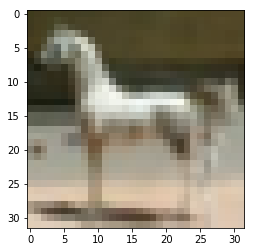

In [5]:
plt.imshow((x_train[150,:,:,:]+1)/2)

## architecture

In [6]:
image_dim = (32,32,3)
latent_dim = 100

generator_initial_dim = (4, 4, 128)

generator_activation = 'leaky_relu'
critic_activation = 'leaky_relu'

critic_learning_rate = 0.00005,
generator_learning_rate = 0.00005,
generator_batch_norm_momentum = 0.8
critic_batch_norm_momentum = None
critic_dense_dim = 0
generator_dropout_rate = None
critic_dropout_rate = None

generator_convolutional_params = [
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 64, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 32, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 3, 'kernel_size': (5, 5), 'upsample': 1, },
    ]

critic_convolutional_params = [
    {'strides': (2, 2), 'filters': 32, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 64, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 128, 'kernel_size': (5, 5),},
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5),},
    ]

In [7]:
if mode == 'build':
    gan = WGAN(
        image_dim=image_dim,
        latent_dim=latent_dim,
        generator_initial_dim=generator_initial_dim,
        critic_dense_dim=critic_dense_dim,
        generator_activation=generator_activation,
        critic_activation=critic_activation,
        generator_convolutional_params=generator_convolutional_params,
        critic_learning_rate = critic_learning_rate,
        generator_learning_rate = generator_learning_rate,
        critic_convolutional_params=critic_convolutional_params,
        generator_batch_norm_momentum=generator_batch_norm_momentum,
        critic_batch_norm_momentum=critic_batch_norm_momentum,
        generator_dropout_rate=generator_dropout_rate,
        critic_dropout_rate=critic_dropout_rate,
        )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))








W0607 21:01:12.244626 140303957808896 deprecation.py:506] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
gan.critic_model.summary()

Model: "critic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv2d_0 (Conv2D)     (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv2d_1 (Conv2D)     (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv2d_2 (Conv2D)     (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)        

In [9]:
gan.generator_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv2d_0 (Conv2D)  (None, 8, 8, 128)     

## training

In [10]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5 # using double here, because book separates true and generated examples.
CLIP_THRESHOLD = 0.01

In [11]:
gan.train(     
    x_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , run_folder=RUN_FOLDER
    , print_every_n_batches=PRINT_EVERY_N_BATCHES
    , critic_training_steps=N_CRITIC
    , clip_threshold=CLIP_THRESHOLD
    , alternating_critic=False
)

W0607 21:01:14.302943 140303957808896 module_wrapper.py:139] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0  disc. loss: (v: -0.001 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000


/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1  disc. loss: (v: -0.002 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2  disc. loss: (v: -0.004 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.003 acc.: 0.000
epoch: 3  disc. loss: (v: -0.014 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.012 acc.: 0.000
epoch: 4  disc. loss: (v: -0.045 g: 0.003) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.045 acc.: 0.000
epoch: 5  disc. loss: (v: -0.099 g: 0.021) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.137 acc.: 0.000
epoch: 6  disc. loss: (v: -0.222 g: 0.070) acc.: (v: 0.031 g: 0.000)  gen. loss:-0.342 acc.: 0.078
epoch: 7  disc. loss: (v: -0.446 g: 0.101) acc.: (v: 0.367 g: 0.000)  gen. loss:-0.764 acc.: 0.797
epoch: 8  disc. loss: (v: -0.896 g: 0.142) acc.: (v: 0.625 g: 0.000)  gen. loss:-1.553 acc.: 0.414
epoch: 9  disc. loss: (v: -1.355 g: 0.232) acc.: (v: 0.461 g: 0.000)  gen. loss:-2.717 acc.: 0.094
epoch: 10  disc. loss: (v: -2.483 g: 0.232) acc.: (v: 0.227 g: 0.000)  gen. loss:-4.594 acc.: 0.016
epoch:

epoch: 84  disc. loss: (v: -10.204 g: 7.489) acc.: (v: 0.031 g: 0.000)  gen. loss:-7.812 acc.: 0.031
epoch: 85  disc. loss: (v: -7.554 g: 5.987) acc.: (v: 0.078 g: 0.000)  gen. loss:-4.572 acc.: 0.062
epoch: 86  disc. loss: (v: -12.319 g: 7.593) acc.: (v: 0.023 g: 0.000)  gen. loss:-12.367 acc.: 0.039
epoch: 87  disc. loss: (v: -15.260 g: 13.889) acc.: (v: 0.023 g: 0.000)  gen. loss:-17.155 acc.: 0.016
epoch: 88  disc. loss: (v: -11.959 g: 14.576) acc.: (v: 0.039 g: 0.000)  gen. loss:-12.756 acc.: 0.023
epoch: 89  disc. loss: (v: -13.373 g: 12.705) acc.: (v: 0.016 g: 0.000)  gen. loss:-15.965 acc.: 0.023
epoch: 90  disc. loss: (v: -11.748 g: 11.993) acc.: (v: 0.016 g: 0.000)  gen. loss:-13.230 acc.: 0.008
epoch: 91  disc. loss: (v: -10.331 g: 9.454) acc.: (v: 0.016 g: 0.000)  gen. loss:-11.954 acc.: 0.016
epoch: 92  disc. loss: (v: -13.284 g: 11.328) acc.: (v: 0.016 g: 0.000)  gen. loss:-16.742 acc.: 0.023
epoch: 93  disc. loss: (v: -13.560 g: 16.239) acc.: (v: 0.023 g: 0.000)  gen. lo

epoch: 166  disc. loss: (v: -0.324 g: 0.497) acc.: (v: 0.281 g: 0.000)  gen. loss:-0.322 acc.: 0.219
epoch: 167  disc. loss: (v: 0.115 g: -0.005) acc.: (v: 0.000 g: 0.039)  gen. loss:-0.158 acc.: 0.031
epoch: 168  disc. loss: (v: -0.253 g: 0.296) acc.: (v: 0.203 g: 0.000)  gen. loss:-0.416 acc.: 0.320
epoch: 169  disc. loss: (v: -0.253 g: 0.262) acc.: (v: 0.156 g: 0.000)  gen. loss:-0.447 acc.: 0.414
epoch: 170  disc. loss: (v: -0.021 g: -0.080) acc.: (v: 0.102 g: 0.117)  gen. loss:0.512 acc.: 0.008
epoch: 171  disc. loss: (v: -0.380 g: 0.371) acc.: (v: 0.320 g: 0.000)  gen. loss:-0.887 acc.: 0.758
epoch: 172  disc. loss: (v: -0.176 g: -0.073) acc.: (v: 0.156 g: 0.102)  gen. loss:0.247 acc.: 0.023
epoch: 173  disc. loss: (v: -0.372 g: 0.167) acc.: (v: 0.297 g: 0.000)  gen. loss:-0.295 acc.: 0.219
epoch: 174  disc. loss: (v: -0.533 g: 0.316) acc.: (v: 0.523 g: 0.000)  gen. loss:-0.463 acc.: 0.406
epoch: 175  disc. loss: (v: 0.591 g: -0.888) acc.: (v: 0.086 g: 0.578)  gen. loss:1.095 acc

epoch: 248  disc. loss: (v: 1.161 g: -1.467) acc.: (v: 0.016 g: 0.547)  gen. loss:1.767 acc.: 0.000
epoch: 249  disc. loss: (v: -0.069 g: -0.080) acc.: (v: 0.164 g: 0.047)  gen. loss:-0.534 acc.: 0.492
epoch: 250  disc. loss: (v: 0.964 g: -1.008) acc.: (v: 0.000 g: 0.680)  gen. loss:1.107 acc.: 0.000
epoch: 251  disc. loss: (v: -0.007 g: 0.079) acc.: (v: 0.109 g: 0.016)  gen. loss:-0.546 acc.: 0.555
epoch: 252  disc. loss: (v: 0.385 g: -0.335) acc.: (v: 0.031 g: 0.328)  gen. loss:0.249 acc.: 0.016
epoch: 253  disc. loss: (v: -0.083 g: 0.137) acc.: (v: 0.141 g: 0.008)  gen. loss:-0.415 acc.: 0.344
epoch: 254  disc. loss: (v: -0.580 g: 0.580) acc.: (v: 0.602 g: 0.000)  gen. loss:-0.727 acc.: 0.844
epoch: 255  disc. loss: (v: -0.429 g: 0.394) acc.: (v: 0.375 g: 0.000)  gen. loss:-0.521 acc.: 0.570
epoch: 256  disc. loss: (v: -1.033 g: 0.848) acc.: (v: 0.898 g: 0.000)  gen. loss:-0.724 acc.: 0.906
epoch: 257  disc. loss: (v: -1.179 g: 1.018) acc.: (v: 0.852 g: 0.000)  gen. loss:-1.066 acc.

epoch: 330  disc. loss: (v: 0.463 g: -0.781) acc.: (v: 0.000 g: 0.805)  gen. loss:1.195 acc.: 0.000
epoch: 331  disc. loss: (v: -1.015 g: 0.668) acc.: (v: 0.750 g: 0.000)  gen. loss:-1.168 acc.: 0.781
epoch: 332  disc. loss: (v: -1.214 g: 0.924) acc.: (v: 0.734 g: 0.000)  gen. loss:-0.989 acc.: 0.938
epoch: 333  disc. loss: (v: 0.583 g: -1.133) acc.: (v: 0.078 g: 0.586)  gen. loss:1.489 acc.: 0.000
epoch: 334  disc. loss: (v: -0.513 g: 0.355) acc.: (v: 0.484 g: 0.000)  gen. loss:-0.728 acc.: 0.836
epoch: 335  disc. loss: (v: -2.226 g: 1.847) acc.: (v: 0.242 g: 0.000)  gen. loss:-2.415 acc.: 0.156
epoch: 336  disc. loss: (v: -0.742 g: 0.661) acc.: (v: 0.734 g: 0.000)  gen. loss:-0.405 acc.: 0.336
epoch: 337  disc. loss: (v: -0.239 g: 0.141) acc.: (v: 0.312 g: 0.070)  gen. loss:-0.190 acc.: 0.258
epoch: 338  disc. loss: (v: -2.156 g: 2.003) acc.: (v: 0.281 g: 0.000)  gen. loss:-2.358 acc.: 0.109
epoch: 339  disc. loss: (v: -0.834 g: 0.866) acc.: (v: 0.859 g: 0.000)  gen. loss:-0.441 acc.

epoch: 412  disc. loss: (v: -0.231 g: -0.080) acc.: (v: 0.234 g: 0.109)  gen. loss:0.526 acc.: 0.039
epoch: 413  disc. loss: (v: 1.744 g: -2.084) acc.: (v: 0.055 g: 0.211)  gen. loss:1.960 acc.: 0.023
epoch: 414  disc. loss: (v: -0.643 g: 0.368) acc.: (v: 0.641 g: 0.000)  gen. loss:-0.901 acc.: 0.789
epoch: 415  disc. loss: (v: -1.563 g: 1.334) acc.: (v: 0.445 g: 0.000)  gen. loss:-0.928 acc.: 0.648
epoch: 416  disc. loss: (v: 1.742 g: -2.505) acc.: (v: 0.047 g: 0.172)  gen. loss:2.698 acc.: 0.055
epoch: 417  disc. loss: (v: -0.642 g: 0.254) acc.: (v: 0.602 g: 0.000)  gen. loss:-0.958 acc.: 0.602
epoch: 418  disc. loss: (v: -1.794 g: 1.602) acc.: (v: 0.328 g: 0.000)  gen. loss:-0.792 acc.: 0.445
epoch: 419  disc. loss: (v: 0.816 g: -1.334) acc.: (v: 0.000 g: 0.469)  gen. loss:1.644 acc.: 0.000
epoch: 420  disc. loss: (v: -1.368 g: 0.853) acc.: (v: 0.430 g: 0.016)  gen. loss:-1.195 acc.: 0.352
epoch: 421  disc. loss: (v: 0.565 g: -1.052) acc.: (v: 0.008 g: 0.602)  gen. loss:1.939 acc.: 

epoch: 494  disc. loss: (v: 5.089 g: -6.782) acc.: (v: 0.023 g: 0.039)  gen. loss:5.330 acc.: 0.055
epoch: 495  disc. loss: (v: 1.329 g: -1.671) acc.: (v: 0.109 g: 0.195)  gen. loss:1.302 acc.: 0.164
epoch: 496  disc. loss: (v: -5.366 g: 3.745) acc.: (v: 0.039 g: 0.000)  gen. loss:-4.921 acc.: 0.117
epoch: 497  disc. loss: (v: -2.921 g: 3.115) acc.: (v: 0.164 g: 0.000)  gen. loss:-1.397 acc.: 0.492
epoch: 498  disc. loss: (v: 1.844 g: -2.656) acc.: (v: 0.070 g: 0.141)  gen. loss:3.175 acc.: 0.062
epoch: 499  disc. loss: (v: -1.055 g: 0.611) acc.: (v: 0.680 g: 0.000)  gen. loss:-1.387 acc.: 0.391
epoch: 500  disc. loss: (v: 1.800 g: -2.168) acc.: (v: 0.000 g: 0.266)  gen. loss:2.061 acc.: 0.000
epoch: 501  disc. loss: (v: -1.241 g: 0.934) acc.: (v: 0.461 g: 0.031)  gen. loss:-1.151 acc.: 0.406
epoch: 502  disc. loss: (v: 0.395 g: -0.766) acc.: (v: 0.055 g: 0.586)  gen. loss:0.683 acc.: 0.000
epoch: 503  disc. loss: (v: 0.751 g: -1.014) acc.: (v: 0.039 g: 0.461)  gen. loss:0.393 acc.: 0.

epoch: 576  disc. loss: (v: 0.855 g: -1.401) acc.: (v: 0.055 g: 0.523)  gen. loss:2.226 acc.: 0.000
epoch: 577  disc. loss: (v: 1.291 g: -1.684) acc.: (v: 0.008 g: 0.344)  gen. loss:0.202 acc.: 0.047
epoch: 578  disc. loss: (v: -1.690 g: 1.022) acc.: (v: 0.352 g: 0.008)  gen. loss:-1.686 acc.: 0.281
epoch: 579  disc. loss: (v: -4.828 g: 4.679) acc.: (v: 0.102 g: 0.000)  gen. loss:-3.601 acc.: 0.125
epoch: 580  disc. loss: (v: -4.285 g: 3.884) acc.: (v: 0.023 g: 0.000)  gen. loss:-2.222 acc.: 0.328
epoch: 581  disc. loss: (v: -5.964 g: 5.498) acc.: (v: 0.047 g: 0.000)  gen. loss:-4.482 acc.: 0.102
epoch: 582  disc. loss: (v: -0.989 g: 0.240) acc.: (v: 0.406 g: 0.133)  gen. loss:3.656 acc.: 0.039
epoch: 583  disc. loss: (v: -9.860 g: 6.744) acc.: (v: 0.023 g: 0.070)  gen. loss:-10.292 acc.: 0.023
epoch: 584  disc. loss: (v: -7.459 g: 7.091) acc.: (v: 0.031 g: 0.008)  gen. loss:-6.723 acc.: 0.016
epoch: 585  disc. loss: (v: 0.348 g: -1.156) acc.: (v: 0.242 g: 0.391)  gen. loss:3.218 acc.:

epoch: 658  disc. loss: (v: -3.459 g: 2.950) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.721 acc.: 0.203
epoch: 659  disc. loss: (v: -0.678 g: 0.747) acc.: (v: 0.094 g: 0.109)  gen. loss:-2.007 acc.: 0.125
epoch: 660  disc. loss: (v: -9.059 g: 8.270) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.190 acc.: 0.000
epoch: 661  disc. loss: (v: -5.339 g: 5.219) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.112 acc.: 0.047
epoch: 662  disc. loss: (v: -6.527 g: 6.923) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.673 acc.: 0.008
epoch: 663  disc. loss: (v: -8.321 g: 8.069) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.739 acc.: 0.000
epoch: 664  disc. loss: (v: -2.625 g: 2.450) acc.: (v: 0.141 g: 0.055)  gen. loss:-2.071 acc.: 0.156
epoch: 665  disc. loss: (v: -4.400 g: 4.461) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.542 acc.: 0.000
epoch: 666  disc. loss: (v: -13.934 g: 11.007) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.332 acc.: 0.000
epoch: 667  disc. loss: (v: -6.302 g: 7.196) acc.: (v: 0.000 g: 0.000)  gen. loss:-3.6

epoch: 740  disc. loss: (v: -10.024 g: 8.795) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.451 acc.: 0.000
epoch: 741  disc. loss: (v: -1.629 g: 1.162) acc.: (v: 0.328 g: 0.047)  gen. loss:1.549 acc.: 0.141
epoch: 742  disc. loss: (v: 0.700 g: -0.477) acc.: (v: 0.219 g: 0.266)  gen. loss:0.471 acc.: 0.195
epoch: 743  disc. loss: (v: -4.759 g: 4.475) acc.: (v: 0.023 g: 0.000)  gen. loss:-6.872 acc.: 0.000
epoch: 744  disc. loss: (v: -7.400 g: 7.574) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.401 acc.: 0.000
epoch: 745  disc. loss: (v: 1.632 g: -2.639) acc.: (v: 0.109 g: 0.188)  gen. loss:5.528 acc.: 0.008
epoch: 746  disc. loss: (v: 0.804 g: -0.310) acc.: (v: 0.234 g: 0.219)  gen. loss:-1.025 acc.: 0.305
epoch: 747  disc. loss: (v: -3.366 g: 2.977) acc.: (v: 0.023 g: 0.000)  gen. loss:-4.611 acc.: 0.000
epoch: 748  disc. loss: (v: -3.377 g: 2.930) acc.: (v: 0.031 g: 0.000)  gen. loss:-4.938 acc.: 0.000
epoch: 749  disc. loss: (v: -0.010 g: -0.561) acc.: (v: 0.375 g: 0.227)  gen. loss:2.159 acc

epoch: 822  disc. loss: (v: -7.769 g: 5.344) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.711 acc.: 0.031
epoch: 823  disc. loss: (v: -7.158 g: 7.093) acc.: (v: 0.031 g: 0.000)  gen. loss:-5.485 acc.: 0.078
epoch: 824  disc. loss: (v: 6.069 g: -8.588) acc.: (v: 0.023 g: 0.008)  gen. loss:8.615 acc.: 0.008
epoch: 825  disc. loss: (v: 0.932 g: -1.189) acc.: (v: 0.078 g: 0.273)  gen. loss:-1.537 acc.: 0.516
epoch: 826  disc. loss: (v: -11.451 g: 9.051) acc.: (v: 0.016 g: 0.016)  gen. loss:-12.549 acc.: 0.023
epoch: 827  disc. loss: (v: -0.178 g: -1.330) acc.: (v: 0.172 g: 0.320)  gen. loss:5.128 acc.: 0.023
epoch: 828  disc. loss: (v: 4.280 g: -5.699) acc.: (v: 0.055 g: 0.078)  gen. loss:6.079 acc.: 0.031
epoch: 829  disc. loss: (v: -3.976 g: 2.888) acc.: (v: 0.031 g: 0.000)  gen. loss:-3.320 acc.: 0.141
epoch: 830  disc. loss: (v: -3.114 g: 2.077) acc.: (v: 0.125 g: 0.016)  gen. loss:0.704 acc.: 0.016
epoch: 831  disc. loss: (v: -0.040 g: -1.068) acc.: (v: 0.227 g: 0.273)  gen. loss:1.021 ac

epoch: 904  disc. loss: (v: 3.429 g: -6.649) acc.: (v: 0.047 g: 0.062)  gen. loss:6.307 acc.: 0.039
epoch: 905  disc. loss: (v: -1.113 g: -0.030) acc.: (v: 0.133 g: 0.078)  gen. loss:-0.978 acc.: 0.195
epoch: 906  disc. loss: (v: -9.797 g: 7.325) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.285 acc.: 0.039
epoch: 907  disc. loss: (v: 1.131 g: -3.775) acc.: (v: 0.172 g: 0.078)  gen. loss:7.145 acc.: 0.047
epoch: 908  disc. loss: (v: -10.125 g: 8.232) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.664 acc.: 0.031
epoch: 909  disc. loss: (v: -8.515 g: 6.937) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.597 acc.: 0.008
epoch: 910  disc. loss: (v: 4.896 g: -8.462) acc.: (v: 0.039 g: 0.070)  gen. loss:6.111 acc.: 0.062
epoch: 911  disc. loss: (v: -4.901 g: 3.767) acc.: (v: 0.031 g: 0.047)  gen. loss:-6.273 acc.: 0.000
epoch: 912  disc. loss: (v: -1.727 g: 0.205) acc.: (v: 0.094 g: 0.133)  gen. loss:-0.736 acc.: 0.102
epoch: 913  disc. loss: (v: -6.368 g: 4.601) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.466 ac

epoch: 985  disc. loss: (v: -13.723 g: 10.752) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.526 acc.: 0.008
epoch: 986  disc. loss: (v: 6.947 g: -7.860) acc.: (v: 0.031 g: 0.055)  gen. loss:4.934 acc.: 0.039
epoch: 987  disc. loss: (v: -2.319 g: 0.508) acc.: (v: 0.203 g: 0.086)  gen. loss:3.528 acc.: 0.078
epoch: 988  disc. loss: (v: -7.597 g: 5.085) acc.: (v: 0.016 g: 0.047)  gen. loss:-7.949 acc.: 0.031
epoch: 989  disc. loss: (v: 8.667 g: -11.718) acc.: (v: 0.023 g: 0.008)  gen. loss:9.234 acc.: 0.016
epoch: 990  disc. loss: (v: -8.736 g: 7.237) acc.: (v: 0.000 g: 0.008)  gen. loss:-5.463 acc.: 0.031
epoch: 991  disc. loss: (v: -9.057 g: 7.491) acc.: (v: 0.008 g: 0.000)  gen. loss:-4.608 acc.: 0.008
epoch: 992  disc. loss: (v: -5.749 g: 3.666) acc.: (v: 0.008 g: 0.016)  gen. loss:-7.799 acc.: 0.000
epoch: 993  disc. loss: (v: 0.247 g: -2.960) acc.: (v: 0.062 g: 0.023)  gen. loss:5.853 acc.: 0.023
epoch: 994  disc. loss: (v: -9.490 g: 6.792) acc.: (v: 0.008 g: 0.016)  gen. loss:-10.111 a

epoch: 1066  disc. loss: (v: 9.553 g: -14.868) acc.: (v: 0.016 g: 0.023)  gen. loss:10.011 acc.: 0.016
epoch: 1067  disc. loss: (v: -6.432 g: 4.537) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.516 acc.: 0.000
epoch: 1068  disc. loss: (v: -5.504 g: 3.333) acc.: (v: 0.000 g: 0.000)  gen. loss:-1.710 acc.: 0.234
epoch: 1069  disc. loss: (v: -7.273 g: 5.645) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.229 acc.: 0.211
epoch: 1070  disc. loss: (v: -18.699 g: 17.288) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.741 acc.: 0.000
epoch: 1071  disc. loss: (v: -9.341 g: 7.842) acc.: (v: 0.000 g: 0.000)  gen. loss:2.544 acc.: 0.023
epoch: 1072  disc. loss: (v: -0.497 g: -1.665) acc.: (v: 0.117 g: 0.102)  gen. loss:2.294 acc.: 0.086
epoch: 1073  disc. loss: (v: -17.959 g: 12.529) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.940 acc.: 0.031
epoch: 1074  disc. loss: (v: -0.369 g: -1.950) acc.: (v: 0.047 g: 0.062)  gen. loss:4.556 acc.: 0.047
epoch: 1075  disc. loss: (v: -0.743 g: -1.301) acc.: (v: 0.117 g: 0.047)  ge

epoch: 1146  disc. loss: (v: 7.952 g: -11.731) acc.: (v: 0.016 g: 0.047)  gen. loss:9.538 acc.: 0.023
epoch: 1147  disc. loss: (v: -10.489 g: 8.783) acc.: (v: 0.008 g: 0.000)  gen. loss:-8.196 acc.: 0.023
epoch: 1148  disc. loss: (v: 0.352 g: -1.801) acc.: (v: 0.156 g: 0.070)  gen. loss:2.688 acc.: 0.133
epoch: 1149  disc. loss: (v: 5.441 g: -5.820) acc.: (v: 0.055 g: 0.070)  gen. loss:-0.418 acc.: 0.078
epoch: 1150  disc. loss: (v: -9.303 g: 6.796) acc.: (v: 0.016 g: 0.000)  gen. loss:-10.440 acc.: 0.008
epoch: 1151  disc. loss: (v: 7.702 g: -11.788) acc.: (v: 0.008 g: 0.016)  gen. loss:8.445 acc.: 0.039
epoch: 1152  disc. loss: (v: -17.126 g: 13.374) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.752 acc.: 0.023
epoch: 1153  disc. loss: (v: -10.016 g: 8.806) acc.: (v: 0.000 g: 0.000)  gen. loss:-2.415 acc.: 0.086
epoch: 1154  disc. loss: (v: 4.866 g: -5.811) acc.: (v: 0.008 g: 0.047)  gen. loss:3.060 acc.: 0.109
epoch: 1155  disc. loss: (v: -5.701 g: 2.711) acc.: (v: 0.031 g: 0.055)  gen. 

epoch: 1226  disc. loss: (v: -5.696 g: 3.580) acc.: (v: 0.016 g: 0.086)  gen. loss:-11.165 acc.: 0.039
epoch: 1227  disc. loss: (v: 2.808 g: -4.507) acc.: (v: 0.062 g: 0.039)  gen. loss:3.911 acc.: 0.031
epoch: 1228  disc. loss: (v: -6.616 g: 4.538) acc.: (v: 0.031 g: 0.094)  gen. loss:-5.927 acc.: 0.055
epoch: 1229  disc. loss: (v: -2.337 g: 0.481) acc.: (v: 0.211 g: 0.109)  gen. loss:-1.606 acc.: 0.211
epoch: 1230  disc. loss: (v: 7.382 g: -10.206) acc.: (v: 0.039 g: 0.055)  gen. loss:7.531 acc.: 0.062
epoch: 1231  disc. loss: (v: -0.676 g: -1.101) acc.: (v: 0.219 g: 0.281)  gen. loss:-3.579 acc.: 0.086
epoch: 1232  disc. loss: (v: -5.369 g: 3.117) acc.: (v: 0.055 g: 0.070)  gen. loss:-5.680 acc.: 0.094
epoch: 1233  disc. loss: (v: 7.738 g: -12.085) acc.: (v: 0.016 g: 0.016)  gen. loss:11.999 acc.: 0.023
epoch: 1234  disc. loss: (v: -12.234 g: 9.247) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.512 acc.: 0.008
epoch: 1235  disc. loss: (v: 1.908 g: -5.111) acc.: (v: 0.055 g: 0.055)  gen. 

epoch: 1306  disc. loss: (v: 6.107 g: -10.211) acc.: (v: 0.055 g: 0.023)  gen. loss:9.023 acc.: 0.039
epoch: 1307  disc. loss: (v: -9.596 g: 7.337) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.071 acc.: 0.016
epoch: 1308  disc. loss: (v: 2.681 g: -4.453) acc.: (v: 0.117 g: 0.078)  gen. loss:7.651 acc.: 0.008
epoch: 1309  disc. loss: (v: -2.573 g: 0.625) acc.: (v: 0.141 g: 0.125)  gen. loss:4.342 acc.: 0.070
epoch: 1310  disc. loss: (v: -7.840 g: 5.493) acc.: (v: 0.023 g: 0.039)  gen. loss:-10.646 acc.: 0.031
epoch: 1311  disc. loss: (v: 9.537 g: -11.964) acc.: (v: 0.016 g: 0.016)  gen. loss:5.530 acc.: 0.062
epoch: 1312  disc. loss: (v: -16.343 g: 13.069) acc.: (v: 0.008 g: 0.023)  gen. loss:-15.280 acc.: 0.055
epoch: 1313  disc. loss: (v: 7.414 g: -12.163) acc.: (v: 0.031 g: 0.055)  gen. loss:12.382 acc.: 0.008
epoch: 1314  disc. loss: (v: 0.043 g: -1.531) acc.: (v: 0.094 g: 0.094)  gen. loss:-0.098 acc.: 0.125
epoch: 1315  disc. loss: (v: -4.217 g: 2.577) acc.: (v: 0.031 g: 0.000)  gen. 

epoch: 1386  disc. loss: (v: 0.366 g: -2.301) acc.: (v: 0.141 g: 0.117)  gen. loss:2.078 acc.: 0.055
epoch: 1387  disc. loss: (v: -7.509 g: 5.814) acc.: (v: 0.031 g: 0.055)  gen. loss:-8.573 acc.: 0.039
epoch: 1388  disc. loss: (v: 2.579 g: -5.091) acc.: (v: 0.055 g: 0.039)  gen. loss:5.955 acc.: 0.031
epoch: 1389  disc. loss: (v: -15.911 g: 13.742) acc.: (v: 0.000 g: 0.039)  gen. loss:-17.345 acc.: 0.000
epoch: 1390  disc. loss: (v: -14.776 g: 17.627) acc.: (v: 0.008 g: 0.008)  gen. loss:-3.984 acc.: 0.109
epoch: 1391  disc. loss: (v: 12.204 g: -14.303) acc.: (v: 0.000 g: 0.023)  gen. loss:11.173 acc.: 0.008
epoch: 1392  disc. loss: (v: -13.270 g: 10.702) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.246 acc.: 0.008
epoch: 1393  disc. loss: (v: -10.124 g: 8.287) acc.: (v: 0.008 g: 0.008)  gen. loss:-8.666 acc.: 0.008
epoch: 1394  disc. loss: (v: 2.134 g: -5.962) acc.: (v: 0.070 g: 0.062)  gen. loss:12.933 acc.: 0.023
epoch: 1395  disc. loss: (v: -7.983 g: 6.172) acc.: (v: 0.000 g: 0.000)  

epoch: 1466  disc. loss: (v: -15.176 g: 9.673) acc.: (v: 0.039 g: 0.055)  gen. loss:-18.453 acc.: 0.039
epoch: 1467  disc. loss: (v: -18.176 g: 19.692) acc.: (v: 0.000 g: 0.016)  gen. loss:-9.338 acc.: 0.016
epoch: 1468  disc. loss: (v: 4.655 g: -8.569) acc.: (v: 0.055 g: 0.023)  gen. loss:7.016 acc.: 0.008
epoch: 1469  disc. loss: (v: -7.793 g: 5.522) acc.: (v: 0.000 g: 0.023)  gen. loss:-5.176 acc.: 0.008
epoch: 1470  disc. loss: (v: -27.544 g: 23.012) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.100 acc.: 0.000
epoch: 1471  disc. loss: (v: -6.487 g: 3.158) acc.: (v: 0.023 g: 0.070)  gen. loss:3.898 acc.: 0.016
epoch: 1472  disc. loss: (v: 3.805 g: -5.879) acc.: (v: 0.031 g: 0.016)  gen. loss:4.529 acc.: 0.039
epoch: 1473  disc. loss: (v: -21.394 g: 16.747) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.562 acc.: 0.000
epoch: 1474  disc. loss: (v: -14.189 g: 12.032) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.313 acc.: 0.000
epoch: 1475  disc. loss: (v: 6.499 g: -9.704) acc.: (v: 0.047 g: 0.039) 

epoch: 1546  disc. loss: (v: -21.901 g: 16.252) acc.: (v: 0.000 g: 0.016)  gen. loss:-24.327 acc.: 0.008
epoch: 1547  disc. loss: (v: -15.078 g: 13.579) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.174 acc.: 0.008
epoch: 1548  disc. loss: (v: 13.963 g: -13.901) acc.: (v: 0.039 g: 0.008)  gen. loss:12.904 acc.: 0.008
epoch: 1549  disc. loss: (v: 2.740 g: -3.666) acc.: (v: 0.031 g: 0.078)  gen. loss:1.124 acc.: 0.141
epoch: 1550  disc. loss: (v: -12.482 g: 9.704) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.239 acc.: 0.047
epoch: 1551  disc. loss: (v: 3.180 g: -4.956) acc.: (v: 0.109 g: 0.102)  gen. loss:1.321 acc.: 0.156
epoch: 1552  disc. loss: (v: 10.091 g: -12.690) acc.: (v: 0.023 g: 0.062)  gen. loss:8.574 acc.: 0.023
epoch: 1553  disc. loss: (v: -22.491 g: 17.252) acc.: (v: 0.016 g: 0.008)  gen. loss:-23.079 acc.: 0.047
epoch: 1554  disc. loss: (v: -7.321 g: 5.208) acc.: (v: 0.000 g: 0.000)  gen. loss:-1.271 acc.: 0.102
epoch: 1555  disc. loss: (v: -10.626 g: 8.518) acc.: (v: 0.000 g: 0.00

epoch: 1626  disc. loss: (v: -9.249 g: 7.413) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.979 acc.: 0.023
epoch: 1627  disc. loss: (v: -7.918 g: 6.197) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.124 acc.: 0.000
epoch: 1628  disc. loss: (v: -14.229 g: 12.962) acc.: (v: 0.000 g: 0.016)  gen. loss:-10.952 acc.: 0.016
epoch: 1629  disc. loss: (v: 1.342 g: -4.703) acc.: (v: 0.141 g: 0.078)  gen. loss:10.532 acc.: 0.047
epoch: 1630  disc. loss: (v: -5.817 g: 2.982) acc.: (v: 0.078 g: 0.039)  gen. loss:-8.759 acc.: 0.016
epoch: 1631  disc. loss: (v: -6.512 g: 4.654) acc.: (v: 0.000 g: 0.008)  gen. loss:-2.737 acc.: 0.086
epoch: 1632  disc. loss: (v: 8.453 g: -9.560) acc.: (v: 0.031 g: 0.039)  gen. loss:3.016 acc.: 0.062
epoch: 1633  disc. loss: (v: -20.580 g: 16.845) acc.: (v: 0.008 g: 0.016)  gen. loss:-20.481 acc.: 0.023
epoch: 1634  disc. loss: (v: 3.302 g: -8.480) acc.: (v: 0.023 g: 0.055)  gen. loss:15.523 acc.: 0.008
epoch: 1635  disc. loss: (v: 1.660 g: -4.070) acc.: (v: 0.062 g: 0.016)  gen.

epoch: 1706  disc. loss: (v: -2.950 g: 1.599) acc.: (v: 0.102 g: 0.102)  gen. loss:-8.342 acc.: 0.008
epoch: 1707  disc. loss: (v: -7.882 g: 6.015) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.693 acc.: 0.000
epoch: 1708  disc. loss: (v: -13.875 g: 11.410) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.772 acc.: 0.062
epoch: 1709  disc. loss: (v: 10.688 g: -14.157) acc.: (v: 0.000 g: 0.016)  gen. loss:9.126 acc.: 0.008
epoch: 1710  disc. loss: (v: -14.301 g: 11.036) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.278 acc.: 0.016
epoch: 1711  disc. loss: (v: 1.442 g: -6.014) acc.: (v: 0.070 g: 0.047)  gen. loss:13.146 acc.: 0.023
epoch: 1712  disc. loss: (v: -11.408 g: 8.674) acc.: (v: 0.023 g: 0.047)  gen. loss:-11.829 acc.: 0.031
epoch: 1713  disc. loss: (v: -10.263 g: 8.265) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.718 acc.: 0.016
epoch: 1714  disc. loss: (v: 2.655 g: -6.518) acc.: (v: 0.031 g: 0.039)  gen. loss:10.453 acc.: 0.031
epoch: 1715  disc. loss: (v: -19.108 g: 15.042) acc.: (v: 0.000 g: 0.008

epoch: 1786  disc. loss: (v: -3.120 g: 2.125) acc.: (v: 0.133 g: 0.055)  gen. loss:4.322 acc.: 0.086
epoch: 1787  disc. loss: (v: 8.931 g: -11.498) acc.: (v: 0.039 g: 0.016)  gen. loss:10.976 acc.: 0.023
epoch: 1788  disc. loss: (v: -5.976 g: 3.441) acc.: (v: 0.023 g: 0.031)  gen. loss:-7.625 acc.: 0.047
epoch: 1789  disc. loss: (v: 4.404 g: -5.666) acc.: (v: 0.086 g: 0.062)  gen. loss:3.309 acc.: 0.086
epoch: 1790  disc. loss: (v: -2.259 g: 1.136) acc.: (v: 0.172 g: 0.109)  gen. loss:-8.283 acc.: 0.039
epoch: 1791  disc. loss: (v: 11.831 g: -12.029) acc.: (v: 0.008 g: 0.008)  gen. loss:11.210 acc.: 0.023
epoch: 1792  disc. loss: (v: -17.990 g: 15.414) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.658 acc.: 0.008
epoch: 1793  disc. loss: (v: -1.477 g: -0.537) acc.: (v: 0.109 g: 0.086)  gen. loss:3.072 acc.: 0.094
epoch: 1794  disc. loss: (v: 7.050 g: -10.839) acc.: (v: 0.047 g: 0.023)  gen. loss:11.215 acc.: 0.008
epoch: 1795  disc. loss: (v: -18.828 g: 15.182) acc.: (v: 0.023 g: 0.008)  ge

epoch: 1866  disc. loss: (v: 0.940 g: -0.605) acc.: (v: 0.055 g: 0.055)  gen. loss:-4.277 acc.: 0.062
epoch: 1867  disc. loss: (v: -11.688 g: 9.695) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.864 acc.: 0.016
epoch: 1868  disc. loss: (v: 2.046 g: -5.146) acc.: (v: 0.055 g: 0.016)  gen. loss:10.395 acc.: 0.039
epoch: 1869  disc. loss: (v: -14.826 g: 10.075) acc.: (v: 0.031 g: 0.016)  gen. loss:-20.526 acc.: 0.023
epoch: 1870  disc. loss: (v: -5.810 g: 4.276) acc.: (v: 0.008 g: 0.000)  gen. loss:3.213 acc.: 0.070
epoch: 1871  disc. loss: (v: 2.586 g: -4.584) acc.: (v: 0.141 g: 0.078)  gen. loss:3.923 acc.: 0.055
epoch: 1872  disc. loss: (v: -3.404 g: 1.945) acc.: (v: 0.070 g: 0.078)  gen. loss:-4.091 acc.: 0.062
epoch: 1873  disc. loss: (v: -13.066 g: 10.502) acc.: (v: 0.031 g: 0.062)  gen. loss:-12.624 acc.: 0.039
epoch: 1874  disc. loss: (v: 12.678 g: -14.957) acc.: (v: 0.023 g: 0.016)  gen. loss:9.166 acc.: 0.008
epoch: 1875  disc. loss: (v: -13.320 g: 11.877) acc.: (v: 0.008 g: 0.000)  

epoch: 1946  disc. loss: (v: 10.322 g: -11.586) acc.: (v: 0.039 g: 0.008)  gen. loss:6.489 acc.: 0.023
epoch: 1947  disc. loss: (v: 1.869 g: -4.175) acc.: (v: 0.109 g: 0.055)  gen. loss:5.396 acc.: 0.039
epoch: 1948  disc. loss: (v: -8.273 g: 6.599) acc.: (v: 0.000 g: 0.031)  gen. loss:-5.668 acc.: 0.047
epoch: 1949  disc. loss: (v: -7.682 g: 4.735) acc.: (v: 0.031 g: 0.039)  gen. loss:-11.584 acc.: 0.023
epoch: 1950  disc. loss: (v: 8.454 g: -14.255) acc.: (v: 0.023 g: 0.008)  gen. loss:11.102 acc.: 0.008
epoch: 1951  disc. loss: (v: -10.647 g: 9.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.995 acc.: 0.000
epoch: 1952  disc. loss: (v: -27.070 g: 21.884) acc.: (v: 0.016 g: 0.000)  gen. loss:-26.782 acc.: 0.000
epoch: 1953  disc. loss: (v: -6.748 g: 5.836) acc.: (v: 0.016 g: 0.023)  gen. loss:6.771 acc.: 0.055
epoch: 1954  disc. loss: (v: 5.289 g: -9.541) acc.: (v: 0.055 g: 0.008)  gen. loss:8.182 acc.: 0.023
epoch: 1955  disc. loss: (v: -17.526 g: 13.527) acc.: (v: 0.000 g: 0.008)  ge

epoch: 2026  disc. loss: (v: -3.466 g: 0.256) acc.: (v: 0.062 g: 0.023)  gen. loss:5.279 acc.: 0.039
epoch: 2027  disc. loss: (v: -6.660 g: 3.731) acc.: (v: 0.008 g: 0.047)  gen. loss:-2.092 acc.: 0.078
epoch: 2028  disc. loss: (v: -24.847 g: 22.523) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.446 acc.: 0.016
epoch: 2029  disc. loss: (v: -10.277 g: 10.793) acc.: (v: 0.023 g: 0.000)  gen. loss:-2.270 acc.: 0.047
epoch: 2030  disc. loss: (v: -9.493 g: 7.132) acc.: (v: 0.000 g: 0.016)  gen. loss:-1.288 acc.: 0.039
epoch: 2031  disc. loss: (v: -23.147 g: 17.885) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.184 acc.: 0.008
epoch: 2032  disc. loss: (v: -7.351 g: 6.127) acc.: (v: 0.008 g: 0.000)  gen. loss:0.121 acc.: 0.031
epoch: 2033  disc. loss: (v: -3.710 g: 0.785) acc.: (v: 0.047 g: 0.156)  gen. loss:7.801 acc.: 0.039
epoch: 2034  disc. loss: (v: -7.963 g: 5.174) acc.: (v: 0.031 g: 0.039)  gen. loss:-8.802 acc.: 0.047
epoch: 2035  disc. loss: (v: -13.637 g: 13.419) acc.: (v: 0.023 g: 0.008)  ge

epoch: 2106  disc. loss: (v: -10.921 g: 7.384) acc.: (v: 0.070 g: 0.023)  gen. loss:-14.597 acc.: 0.000
epoch: 2107  disc. loss: (v: 7.189 g: -9.989) acc.: (v: 0.000 g: 0.039)  gen. loss:8.276 acc.: 0.039
epoch: 2108  disc. loss: (v: -6.793 g: 5.058) acc.: (v: 0.008 g: 0.000)  gen. loss:-8.334 acc.: 0.000
epoch: 2109  disc. loss: (v: -8.553 g: 6.131) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.075 acc.: 0.008
epoch: 2110  disc. loss: (v: 6.284 g: -10.380) acc.: (v: 0.055 g: 0.039)  gen. loss:13.004 acc.: 0.031
epoch: 2111  disc. loss: (v: -9.999 g: 6.235) acc.: (v: 0.070 g: 0.055)  gen. loss:-13.262 acc.: 0.008
epoch: 2112  disc. loss: (v: -12.102 g: 11.882) acc.: (v: 0.008 g: 0.008)  gen. loss:-2.332 acc.: 0.117
epoch: 2113  disc. loss: (v: 7.175 g: -10.807) acc.: (v: 0.047 g: 0.023)  gen. loss:4.680 acc.: 0.008
epoch: 2114  disc. loss: (v: -26.408 g: 21.689) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.316 acc.: 0.000
epoch: 2115  disc. loss: (v: -21.636 g: 22.968) acc.: (v: 0.000 g: 0.031)

epoch: 2186  disc. loss: (v: 8.640 g: -12.609) acc.: (v: 0.047 g: 0.016)  gen. loss:13.042 acc.: 0.016
epoch: 2187  disc. loss: (v: -0.638 g: -0.978) acc.: (v: 0.078 g: 0.148)  gen. loss:-2.496 acc.: 0.133
epoch: 2188  disc. loss: (v: -5.113 g: 2.798) acc.: (v: 0.055 g: 0.039)  gen. loss:-0.102 acc.: 0.070
epoch: 2189  disc. loss: (v: -6.131 g: 4.267) acc.: (v: 0.008 g: 0.000)  gen. loss:-7.008 acc.: 0.016
epoch: 2190  disc. loss: (v: -10.824 g: 10.344) acc.: (v: 0.023 g: 0.023)  gen. loss:-3.943 acc.: 0.000
epoch: 2191  disc. loss: (v: -22.690 g: 19.194) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.784 acc.: 0.000
epoch: 2192  disc. loss: (v: -10.178 g: 9.272) acc.: (v: 0.000 g: 0.000)  gen. loss:2.793 acc.: 0.078
epoch: 2193  disc. loss: (v: -0.237 g: -2.448) acc.: (v: 0.062 g: 0.023)  gen. loss:2.779 acc.: 0.062
epoch: 2194  disc. loss: (v: -24.862 g: 21.161) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.205 acc.: 0.000
epoch: 2195  disc. loss: (v: -11.292 g: 10.067) acc.: (v: 0.000 g: 0.000

epoch: 2266  disc. loss: (v: -8.536 g: 6.455) acc.: (v: 0.000 g: 0.000)  gen. loss:0.606 acc.: 0.031
epoch: 2267  disc. loss: (v: -12.080 g: 9.550) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.331 acc.: 0.016
epoch: 2268  disc. loss: (v: -9.729 g: 8.307) acc.: (v: 0.000 g: 0.000)  gen. loss:3.352 acc.: 0.047
epoch: 2269  disc. loss: (v: -2.234 g: 0.185) acc.: (v: 0.086 g: 0.070)  gen. loss:-7.354 acc.: 0.016
epoch: 2270  disc. loss: (v: 8.140 g: -11.952) acc.: (v: 0.031 g: 0.023)  gen. loss:8.926 acc.: 0.008
epoch: 2271  disc. loss: (v: -23.106 g: 20.259) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.737 acc.: 0.000
epoch: 2272  disc. loss: (v: -7.350 g: 3.759) acc.: (v: 0.031 g: 0.008)  gen. loss:3.012 acc.: 0.047
epoch: 2273  disc. loss: (v: -13.915 g: 11.627) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.299 acc.: 0.000
epoch: 2274  disc. loss: (v: -21.431 g: 17.188) acc.: (v: 0.000 g: 0.016)  gen. loss:-23.230 acc.: 0.016
epoch: 2275  disc. loss: (v: -12.037 g: 8.733) acc.: (v: 0.000 g: 0.008)  g

epoch: 2346  disc. loss: (v: 4.221 g: -6.358) acc.: (v: 0.047 g: 0.062)  gen. loss:7.327 acc.: 0.039
epoch: 2347  disc. loss: (v: -11.798 g: 9.495) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.678 acc.: 0.031
epoch: 2348  disc. loss: (v: -18.586 g: 17.959) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.955 acc.: 0.008
epoch: 2349  disc. loss: (v: -26.259 g: 24.274) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.884 acc.: 0.000
epoch: 2350  disc. loss: (v: -10.072 g: 8.086) acc.: (v: 0.000 g: 0.000)  gen. loss:-2.573 acc.: 0.031
epoch: 2351  disc. loss: (v: 2.315 g: -5.978) acc.: (v: 0.031 g: 0.039)  gen. loss:4.368 acc.: 0.023
epoch: 2352  disc. loss: (v: -25.853 g: 19.960) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.455 acc.: 0.016
epoch: 2353  disc. loss: (v: -20.038 g: 18.156) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.532 acc.: 0.023
epoch: 2354  disc. loss: (v: 6.094 g: -10.586) acc.: (v: 0.031 g: 0.008)  gen. loss:7.745 acc.: 0.023
epoch: 2355  disc. loss: (v: 3.545 g: -4.684) acc.: (v: 0.070 g: 0.094

epoch: 2426  disc. loss: (v: -4.117 g: 2.756) acc.: (v: 0.047 g: 0.062)  gen. loss:-8.211 acc.: 0.000
epoch: 2427  disc. loss: (v: -18.746 g: 17.872) acc.: (v: 0.016 g: 0.000)  gen. loss:-14.856 acc.: 0.000
epoch: 2428  disc. loss: (v: -10.619 g: 8.740) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.411 acc.: 0.000
epoch: 2429  disc. loss: (v: -18.434 g: 16.411) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.943 acc.: 0.000
epoch: 2430  disc. loss: (v: -8.469 g: 5.788) acc.: (v: 0.039 g: 0.023)  gen. loss:-4.514 acc.: 0.086
epoch: 2431  disc. loss: (v: -16.725 g: 14.815) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.161 acc.: 0.000
epoch: 2432  disc. loss: (v: -6.475 g: 4.365) acc.: (v: 0.039 g: 0.039)  gen. loss:1.520 acc.: 0.023
epoch: 2433  disc. loss: (v: -12.800 g: 8.105) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.301 acc.: 0.008
epoch: 2434  disc. loss: (v: 3.126 g: -4.928) acc.: (v: 0.055 g: 0.086)  gen. loss:4.794 acc.: 0.078
epoch: 2435  disc. loss: (v: -8.922 g: 7.136) acc.: (v: 0.008 g: 0.016) 

epoch: 2506  disc. loss: (v: -14.567 g: 13.272) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.309 acc.: 0.008
epoch: 2507  disc. loss: (v: -4.895 g: 2.635) acc.: (v: 0.055 g: 0.086)  gen. loss:-2.376 acc.: 0.070
epoch: 2508  disc. loss: (v: -11.065 g: 8.671) acc.: (v: 0.023 g: 0.023)  gen. loss:-8.030 acc.: 0.008
epoch: 2509  disc. loss: (v: 10.859 g: -15.293) acc.: (v: 0.008 g: 0.016)  gen. loss:12.622 acc.: 0.016
epoch: 2510  disc. loss: (v: -13.026 g: 9.356) acc.: (v: 0.039 g: 0.039)  gen. loss:-16.214 acc.: 0.023
epoch: 2511  disc. loss: (v: -19.971 g: 16.886) acc.: (v: 0.008 g: 0.023)  gen. loss:-19.541 acc.: 0.016
epoch: 2512  disc. loss: (v: 9.055 g: -12.145) acc.: (v: 0.031 g: 0.047)  gen. loss:16.037 acc.: 0.008
epoch: 2513  disc. loss: (v: 7.013 g: -11.444) acc.: (v: 0.016 g: 0.008)  gen. loss:10.198 acc.: 0.000
epoch: 2514  disc. loss: (v: -19.251 g: 17.084) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.586 acc.: 0.000
epoch: 2515  disc. loss: (v: -4.225 g: 2.114) acc.: (v: 0.039 g: 0

epoch: 2586  disc. loss: (v: 1.854 g: -3.329) acc.: (v: 0.062 g: 0.102)  gen. loss:7.312 acc.: 0.008
epoch: 2587  disc. loss: (v: 1.734 g: -4.864) acc.: (v: 0.062 g: 0.062)  gen. loss:11.457 acc.: 0.016
epoch: 2588  disc. loss: (v: -14.565 g: 8.185) acc.: (v: 0.047 g: 0.023)  gen. loss:-19.938 acc.: 0.047
epoch: 2589  disc. loss: (v: -5.536 g: 4.276) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.341 acc.: 0.000
epoch: 2590  disc. loss: (v: -1.638 g: -0.536) acc.: (v: 0.055 g: 0.070)  gen. loss:2.052 acc.: 0.062
epoch: 2591  disc. loss: (v: 5.247 g: -7.312) acc.: (v: 0.023 g: 0.016)  gen. loss:5.610 acc.: 0.008
epoch: 2592  disc. loss: (v: -9.046 g: 7.042) acc.: (v: 0.016 g: 0.023)  gen. loss:-10.908 acc.: 0.023
epoch: 2593  disc. loss: (v: 0.784 g: -3.056) acc.: (v: 0.148 g: 0.148)  gen. loss:9.377 acc.: 0.023
epoch: 2594  disc. loss: (v: -10.112 g: 7.704) acc.: (v: 0.031 g: 0.039)  gen. loss:-12.047 acc.: 0.016
epoch: 2595  disc. loss: (v: -19.288 g: 16.972) acc.: (v: 0.000 g: 0.000)  gen. 

epoch: 2666  disc. loss: (v: -5.525 g: 2.658) acc.: (v: 0.047 g: 0.016)  gen. loss:-8.911 acc.: 0.008
epoch: 2667  disc. loss: (v: -10.688 g: 8.706) acc.: (v: 0.016 g: 0.016)  gen. loss:-9.883 acc.: 0.016
epoch: 2668  disc. loss: (v: 11.366 g: -16.767) acc.: (v: 0.016 g: 0.008)  gen. loss:11.642 acc.: 0.016
epoch: 2669  disc. loss: (v: 3.974 g: -5.339) acc.: (v: 0.039 g: 0.055)  gen. loss:6.806 acc.: 0.023
epoch: 2670  disc. loss: (v: -15.709 g: 12.000) acc.: (v: 0.023 g: 0.031)  gen. loss:-20.801 acc.: 0.008
epoch: 2671  disc. loss: (v: 3.950 g: -5.953) acc.: (v: 0.031 g: 0.055)  gen. loss:6.531 acc.: 0.055
epoch: 2672  disc. loss: (v: -8.691 g: 7.164) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.713 acc.: 0.008
epoch: 2673  disc. loss: (v: -5.091 g: 2.265) acc.: (v: 0.086 g: 0.047)  gen. loss:-7.187 acc.: 0.031
epoch: 2674  disc. loss: (v: -0.380 g: -0.967) acc.: (v: 0.164 g: 0.148)  gen. loss:2.616 acc.: 0.094
epoch: 2675  disc. loss: (v: 8.138 g: -11.540) acc.: (v: 0.062 g: 0.055)  gen.

epoch: 2746  disc. loss: (v: 12.555 g: -15.408) acc.: (v: 0.000 g: 0.000)  gen. loss:10.459 acc.: 0.008
epoch: 2747  disc. loss: (v: 7.087 g: -9.794) acc.: (v: 0.016 g: 0.023)  gen. loss:12.946 acc.: 0.008
epoch: 2748  disc. loss: (v: -12.140 g: 8.503) acc.: (v: 0.023 g: 0.023)  gen. loss:-12.119 acc.: 0.023
epoch: 2749  disc. loss: (v: 7.394 g: -8.751) acc.: (v: 0.000 g: 0.062)  gen. loss:11.826 acc.: 0.008
epoch: 2750  disc. loss: (v: 4.897 g: -6.146) acc.: (v: 0.008 g: 0.031)  gen. loss:10.444 acc.: 0.016
epoch: 2751  disc. loss: (v: 0.675 g: -2.068) acc.: (v: 0.133 g: 0.094)  gen. loss:-1.366 acc.: 0.125
epoch: 2752  disc. loss: (v: 4.094 g: -4.874) acc.: (v: 0.008 g: 0.039)  gen. loss:11.229 acc.: 0.000
epoch: 2753  disc. loss: (v: -8.903 g: 7.333) acc.: (v: 0.039 g: 0.031)  gen. loss:-10.127 acc.: 0.023
epoch: 2754  disc. loss: (v: 4.728 g: -6.009) acc.: (v: 0.055 g: 0.047)  gen. loss:4.844 acc.: 0.078
epoch: 2755  disc. loss: (v: -15.555 g: 16.290) acc.: (v: 0.008 g: 0.008)  gen

epoch: 2826  disc. loss: (v: 11.275 g: -15.785) acc.: (v: 0.008 g: 0.016)  gen. loss:11.962 acc.: 0.016
epoch: 2827  disc. loss: (v: 8.704 g: -10.556) acc.: (v: 0.000 g: 0.008)  gen. loss:9.999 acc.: 0.000
epoch: 2828  disc. loss: (v: 8.543 g: -9.732) acc.: (v: 0.000 g: 0.016)  gen. loss:14.729 acc.: 0.000
epoch: 2829  disc. loss: (v: -15.556 g: 10.575) acc.: (v: 0.031 g: 0.016)  gen. loss:-18.243 acc.: 0.016
epoch: 2830  disc. loss: (v: -10.999 g: 10.882) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.106 acc.: 0.062
epoch: 2831  disc. loss: (v: 8.639 g: -9.718) acc.: (v: 0.016 g: 0.031)  gen. loss:6.314 acc.: 0.023
epoch: 2832  disc. loss: (v: -3.024 g: 2.091) acc.: (v: 0.086 g: 0.078)  gen. loss:-6.353 acc.: 0.039
epoch: 2833  disc. loss: (v: -15.336 g: 12.609) acc.: (v: 0.023 g: 0.008)  gen. loss:-16.890 acc.: 0.016
epoch: 2834  disc. loss: (v: -22.092 g: 22.898) acc.: (v: 0.023 g: 0.008)  gen. loss:-12.760 acc.: 0.031
epoch: 2835  disc. loss: (v: 9.362 g: -13.472) acc.: (v: 0.008 g: 0.01

epoch: 2906  disc. loss: (v: 7.014 g: -11.145) acc.: (v: 0.062 g: 0.047)  gen. loss:15.065 acc.: 0.000
epoch: 2907  disc. loss: (v: -5.001 g: 3.870) acc.: (v: 0.047 g: 0.062)  gen. loss:-0.053 acc.: 0.133
epoch: 2908  disc. loss: (v: -4.355 g: 2.573) acc.: (v: 0.055 g: 0.047)  gen. loss:-5.675 acc.: 0.039
epoch: 2909  disc. loss: (v: -7.445 g: 6.038) acc.: (v: 0.039 g: 0.039)  gen. loss:-4.496 acc.: 0.078
epoch: 2910  disc. loss: (v: 5.671 g: -8.472) acc.: (v: 0.016 g: 0.047)  gen. loss:5.579 acc.: 0.031
epoch: 2911  disc. loss: (v: -9.874 g: 9.278) acc.: (v: 0.008 g: 0.016)  gen. loss:-13.593 acc.: 0.000
epoch: 2912  disc. loss: (v: -27.519 g: 23.642) acc.: (v: 0.000 g: 0.031)  gen. loss:-24.522 acc.: 0.008
epoch: 2913  disc. loss: (v: -15.262 g: 18.373) acc.: (v: 0.016 g: 0.023)  gen. loss:-3.288 acc.: 0.148
epoch: 2914  disc. loss: (v: 2.374 g: -4.393) acc.: (v: 0.070 g: 0.055)  gen. loss:5.510 acc.: 0.039
epoch: 2915  disc. loss: (v: 2.299 g: -3.716) acc.: (v: 0.078 g: 0.055)  gen.

epoch: 2986  disc. loss: (v: -1.192 g: 0.231) acc.: (v: 0.164 g: 0.141)  gen. loss:-5.825 acc.: 0.047
epoch: 2987  disc. loss: (v: 2.970 g: -4.268) acc.: (v: 0.039 g: 0.094)  gen. loss:-1.760 acc.: 0.047
epoch: 2988  disc. loss: (v: -4.192 g: 3.064) acc.: (v: 0.039 g: 0.086)  gen. loss:-2.799 acc.: 0.070
epoch: 2989  disc. loss: (v: 8.848 g: -10.551) acc.: (v: 0.016 g: 0.023)  gen. loss:3.517 acc.: 0.008
epoch: 2990  disc. loss: (v: -14.368 g: 12.176) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.365 acc.: 0.000
epoch: 2991  disc. loss: (v: -18.262 g: 15.799) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.423 acc.: 0.000
epoch: 2992  disc. loss: (v: -12.253 g: 10.259) acc.: (v: 0.000 g: 0.008)  gen. loss:-6.207 acc.: 0.023
epoch: 2993  disc. loss: (v: -22.790 g: 18.842) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.718 acc.: 0.031
epoch: 2994  disc. loss: (v: -3.076 g: 1.514) acc.: (v: 0.016 g: 0.047)  gen. loss:6.026 acc.: 0.078
epoch: 2995  disc. loss: (v: 1.372 g: -3.324) acc.: (v: 0.086 g: 0.102) 

epoch: 3066  disc. loss: (v: -0.238 g: -0.594) acc.: (v: 0.055 g: 0.062)  gen. loss:-1.914 acc.: 0.211
epoch: 3067  disc. loss: (v: -6.923 g: 4.621) acc.: (v: 0.062 g: 0.039)  gen. loss:-11.384 acc.: 0.047
epoch: 3068  disc. loss: (v: -10.457 g: 8.691) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.124 acc.: 0.000
epoch: 3069  disc. loss: (v: -3.784 g: 1.847) acc.: (v: 0.055 g: 0.078)  gen. loss:3.165 acc.: 0.102
epoch: 3070  disc. loss: (v: -14.769 g: 10.360) acc.: (v: 0.016 g: 0.023)  gen. loss:-22.071 acc.: 0.008
epoch: 3071  disc. loss: (v: 0.475 g: -1.849) acc.: (v: 0.070 g: 0.047)  gen. loss:2.504 acc.: 0.070
epoch: 3072  disc. loss: (v: 3.633 g: -4.264) acc.: (v: 0.023 g: 0.031)  gen. loss:2.900 acc.: 0.023
epoch: 3073  disc. loss: (v: -14.804 g: 11.771) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.659 acc.: 0.008
epoch: 3074  disc. loss: (v: -15.277 g: 14.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.842 acc.: 0.000
epoch: 3075  disc. loss: (v: -2.494 g: 1.422) acc.: (v: 0.016 g: 0.000)  

epoch: 3146  disc. loss: (v: -9.033 g: 8.512) acc.: (v: 0.047 g: 0.016)  gen. loss:-5.824 acc.: 0.078
epoch: 3147  disc. loss: (v: -27.054 g: 22.621) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.217 acc.: 0.016
epoch: 3148  disc. loss: (v: -4.112 g: 1.578) acc.: (v: 0.039 g: 0.047)  gen. loss:1.183 acc.: 0.062
epoch: 3149  disc. loss: (v: -5.008 g: 2.851) acc.: (v: 0.031 g: 0.047)  gen. loss:-1.144 acc.: 0.148
epoch: 3150  disc. loss: (v: -14.631 g: 12.184) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.177 acc.: 0.008
epoch: 3151  disc. loss: (v: -15.467 g: 13.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.543 acc.: 0.062
epoch: 3152  disc. loss: (v: -21.710 g: 19.906) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.812 acc.: 0.000
epoch: 3153  disc. loss: (v: -25.116 g: 24.314) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.881 acc.: 0.000
epoch: 3154  disc. loss: (v: -1.500 g: -1.004) acc.: (v: 0.094 g: 0.055)  gen. loss:4.499 acc.: 0.055
epoch: 3155  disc. loss: (v: -5.266 g: 5.044) acc.: (v: 0.070 g: 0.00

epoch: 3226  disc. loss: (v: -13.741 g: 12.243) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.019 acc.: 0.008
epoch: 3227  disc. loss: (v: -29.412 g: 26.042) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.157 acc.: 0.008
epoch: 3228  disc. loss: (v: -22.121 g: 20.566) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.097 acc.: 0.000
epoch: 3229  disc. loss: (v: -8.611 g: 4.760) acc.: (v: 0.016 g: 0.023)  gen. loss:0.876 acc.: 0.023
epoch: 3230  disc. loss: (v: -14.226 g: 12.475) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.946 acc.: 0.000
epoch: 3231  disc. loss: (v: -25.770 g: 25.249) acc.: (v: 0.023 g: 0.008)  gen. loss:-20.052 acc.: 0.008
epoch: 3232  disc. loss: (v: -20.512 g: 22.176) acc.: (v: 0.039 g: 0.016)  gen. loss:-17.516 acc.: 0.000
epoch: 3233  disc. loss: (v: 11.416 g: -17.357) acc.: (v: 0.008 g: 0.008)  gen. loss:14.306 acc.: 0.016
epoch: 3234  disc. loss: (v: 9.455 g: -6.281) acc.: (v: 0.000 g: 0.023)  gen. loss:6.304 acc.: 0.008
epoch: 3235  disc. loss: (v: -20.392 g: 13.230) acc.: (v: 0.000 

epoch: 3306  disc. loss: (v: -21.624 g: 17.659) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.875 acc.: 0.000
epoch: 3307  disc. loss: (v: -10.491 g: 7.573) acc.: (v: 0.031 g: 0.008)  gen. loss:-0.123 acc.: 0.000
epoch: 3308  disc. loss: (v: 6.463 g: -4.458) acc.: (v: 0.023 g: 0.023)  gen. loss:0.902 acc.: 0.039
epoch: 3309  disc. loss: (v: -21.481 g: 20.403) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.640 acc.: 0.016
epoch: 3310  disc. loss: (v: -22.303 g: 19.925) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.263 acc.: 0.000
epoch: 3311  disc. loss: (v: 0.981 g: -4.944) acc.: (v: 0.031 g: 0.023)  gen. loss:9.783 acc.: 0.031
epoch: 3312  disc. loss: (v: -3.096 g: 1.748) acc.: (v: 0.070 g: 0.047)  gen. loss:0.541 acc.: 0.078
epoch: 3313  disc. loss: (v: -10.859 g: 7.842) acc.: (v: 0.023 g: 0.016)  gen. loss:-13.153 acc.: 0.031
epoch: 3314  disc. loss: (v: -3.859 g: 2.487) acc.: (v: 0.031 g: 0.000)  gen. loss:-0.620 acc.: 0.141
epoch: 3315  disc. loss: (v: 3.512 g: -4.922) acc.: (v: 0.039 g: 0.086)  

epoch: 3386  disc. loss: (v: -17.012 g: 15.186) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.590 acc.: 0.000
epoch: 3387  disc. loss: (v: -29.039 g: 25.631) acc.: (v: 0.008 g: 0.008)  gen. loss:-26.161 acc.: 0.008
epoch: 3388  disc. loss: (v: -15.364 g: 16.451) acc.: (v: 0.039 g: 0.016)  gen. loss:-7.699 acc.: 0.062
epoch: 3389  disc. loss: (v: 8.059 g: -14.066) acc.: (v: 0.000 g: 0.039)  gen. loss:11.080 acc.: 0.039
epoch: 3390  disc. loss: (v: 5.974 g: -7.536) acc.: (v: 0.023 g: 0.016)  gen. loss:6.705 acc.: 0.031
epoch: 3391  disc. loss: (v: -16.772 g: 13.742) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.634 acc.: 0.008
epoch: 3392  disc. loss: (v: -22.222 g: 23.801) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.455 acc.: 0.008
epoch: 3393  disc. loss: (v: -3.891 g: 2.769) acc.: (v: 0.070 g: 0.070)  gen. loss:1.004 acc.: 0.086
epoch: 3394  disc. loss: (v: 7.377 g: -9.916) acc.: (v: 0.047 g: 0.023)  gen. loss:13.389 acc.: 0.016
epoch: 3395  disc. loss: (v: 7.102 g: -6.541) acc.: (v: 0.031 g: 0.04

epoch: 3466  disc. loss: (v: -28.988 g: 25.141) acc.: (v: 0.016 g: 0.000)  gen. loss:-24.372 acc.: 0.016
epoch: 3467  disc. loss: (v: -9.077 g: 7.349) acc.: (v: 0.031 g: 0.023)  gen. loss:-3.656 acc.: 0.062
epoch: 3468  disc. loss: (v: -6.787 g: 5.748) acc.: (v: 0.031 g: 0.008)  gen. loss:-5.399 acc.: 0.062
epoch: 3469  disc. loss: (v: -20.245 g: 16.796) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.002 acc.: 0.000
epoch: 3470  disc. loss: (v: -0.857 g: -1.396) acc.: (v: 0.047 g: 0.102)  gen. loss:6.547 acc.: 0.039
epoch: 3471  disc. loss: (v: 6.051 g: -7.421) acc.: (v: 0.039 g: 0.016)  gen. loss:7.450 acc.: 0.047
epoch: 3472  disc. loss: (v: -15.701 g: 13.737) acc.: (v: 0.016 g: 0.031)  gen. loss:-13.427 acc.: 0.039
epoch: 3473  disc. loss: (v: -2.322 g: 0.015) acc.: (v: 0.062 g: 0.102)  gen. loss:3.387 acc.: 0.047
epoch: 3474  disc. loss: (v: -9.085 g: 7.909) acc.: (v: 0.031 g: 0.031)  gen. loss:-2.225 acc.: 0.109
epoch: 3475  disc. loss: (v: -1.649 g: -0.276) acc.: (v: 0.156 g: 0.164)  g

epoch: 3546  disc. loss: (v: -8.213 g: 7.200) acc.: (v: 0.008 g: 0.000)  gen. loss:-3.046 acc.: 0.086
epoch: 3547  disc. loss: (v: 13.186 g: -12.055) acc.: (v: 0.016 g: 0.016)  gen. loss:8.333 acc.: 0.031
epoch: 3548  disc. loss: (v: -4.684 g: 2.412) acc.: (v: 0.047 g: 0.047)  gen. loss:-4.091 acc.: 0.070
epoch: 3549  disc. loss: (v: 6.270 g: -7.378) acc.: (v: 0.000 g: 0.016)  gen. loss:-6.458 acc.: 0.031
epoch: 3550  disc. loss: (v: -8.635 g: 8.102) acc.: (v: 0.023 g: 0.016)  gen. loss:-4.393 acc.: 0.039
epoch: 3551  disc. loss: (v: 7.626 g: -9.760) acc.: (v: 0.062 g: 0.039)  gen. loss:9.435 acc.: 0.016
epoch: 3552  disc. loss: (v: -10.111 g: 8.808) acc.: (v: 0.008 g: 0.000)  gen. loss:-9.160 acc.: 0.008
epoch: 3553  disc. loss: (v: -19.501 g: 17.547) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.458 acc.: 0.000
epoch: 3554  disc. loss: (v: -11.160 g: 9.870) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.429 acc.: 0.000
epoch: 3555  disc. loss: (v: 5.391 g: -8.107) acc.: (v: 0.039 g: 0.031)  gen

epoch: 3626  disc. loss: (v: -1.673 g: 0.030) acc.: (v: 0.008 g: 0.031)  gen. loss:-3.426 acc.: 0.016
epoch: 3627  disc. loss: (v: -22.175 g: 20.496) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.358 acc.: 0.000
epoch: 3628  disc. loss: (v: -21.536 g: 20.235) acc.: (v: 0.008 g: 0.023)  gen. loss:-14.561 acc.: 0.008
epoch: 3629  disc. loss: (v: -6.995 g: 4.377) acc.: (v: 0.031 g: 0.031)  gen. loss:-8.813 acc.: 0.055
epoch: 3630  disc. loss: (v: -3.417 g: 2.167) acc.: (v: 0.070 g: 0.062)  gen. loss:-1.857 acc.: 0.117
epoch: 3631  disc. loss: (v: -3.184 g: 1.933) acc.: (v: 0.047 g: 0.016)  gen. loss:-5.019 acc.: 0.047
epoch: 3632  disc. loss: (v: -26.380 g: 22.350) acc.: (v: 0.008 g: 0.008)  gen. loss:-31.269 acc.: 0.000
epoch: 3633  disc. loss: (v: -15.671 g: 14.645) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.237 acc.: 0.008
epoch: 3634  disc. loss: (v: -4.422 g: 3.174) acc.: (v: 0.055 g: 0.031)  gen. loss:-4.845 acc.: 0.039
epoch: 3635  disc. loss: (v: 6.434 g: -11.342) acc.: (v: 0.031 g: 0.023

epoch: 3706  disc. loss: (v: -19.046 g: 14.341) acc.: (v: 0.016 g: 0.023)  gen. loss:-22.325 acc.: 0.008
epoch: 3707  disc. loss: (v: -10.255 g: 9.267) acc.: (v: 0.008 g: 0.000)  gen. loss:-4.612 acc.: 0.055
epoch: 3708  disc. loss: (v: 5.592 g: -7.416) acc.: (v: 0.031 g: 0.039)  gen. loss:7.980 acc.: 0.023
epoch: 3709  disc. loss: (v: -14.184 g: 11.175) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.751 acc.: 0.008
epoch: 3710  disc. loss: (v: -15.789 g: 14.685) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.815 acc.: 0.008
epoch: 3711  disc. loss: (v: 1.363 g: -2.648) acc.: (v: 0.031 g: 0.055)  gen. loss:0.158 acc.: 0.070
epoch: 3712  disc. loss: (v: 6.565 g: -7.394) acc.: (v: 0.031 g: 0.016)  gen. loss:3.650 acc.: 0.047
epoch: 3713  disc. loss: (v: -10.344 g: 8.915) acc.: (v: 0.039 g: 0.039)  gen. loss:-8.618 acc.: 0.062
epoch: 3714  disc. loss: (v: -10.703 g: 8.987) acc.: (v: 0.039 g: 0.023)  gen. loss:-8.914 acc.: 0.062
epoch: 3715  disc. loss: (v: 10.076 g: -12.518) acc.: (v: 0.047 g: 0.023)

epoch: 3786  disc. loss: (v: -15.258 g: 12.304) acc.: (v: 0.031 g: 0.016)  gen. loss:-15.192 acc.: 0.016
epoch: 3787  disc. loss: (v: -12.580 g: 9.979) acc.: (v: 0.023 g: 0.016)  gen. loss:-8.581 acc.: 0.031
epoch: 3788  disc. loss: (v: -10.014 g: 7.714) acc.: (v: 0.031 g: 0.047)  gen. loss:-10.761 acc.: 0.016
epoch: 3789  disc. loss: (v: 11.875 g: -16.766) acc.: (v: 0.039 g: 0.016)  gen. loss:11.270 acc.: 0.023
epoch: 3790  disc. loss: (v: 4.590 g: -7.401) acc.: (v: 0.000 g: 0.008)  gen. loss:1.967 acc.: 0.047
epoch: 3791  disc. loss: (v: -11.216 g: 9.028) acc.: (v: 0.008 g: 0.016)  gen. loss:-8.398 acc.: 0.016
epoch: 3792  disc. loss: (v: -22.442 g: 20.077) acc.: (v: 0.008 g: 0.000)  gen. loss:-18.350 acc.: 0.008
epoch: 3793  disc. loss: (v: -15.661 g: 12.861) acc.: (v: 0.008 g: 0.031)  gen. loss:-17.860 acc.: 0.016
epoch: 3794  disc. loss: (v: 10.704 g: -15.265) acc.: (v: 0.016 g: 0.000)  gen. loss:9.009 acc.: 0.039
epoch: 3795  disc. loss: (v: 10.262 g: -12.869) acc.: (v: 0.016 g: 

epoch: 3866  disc. loss: (v: -24.216 g: 21.820) acc.: (v: 0.008 g: 0.008)  gen. loss:-23.171 acc.: 0.008
epoch: 3867  disc. loss: (v: -8.633 g: 6.203) acc.: (v: 0.008 g: 0.023)  gen. loss:0.979 acc.: 0.070
epoch: 3868  disc. loss: (v: -2.027 g: -0.415) acc.: (v: 0.016 g: 0.055)  gen. loss:5.990 acc.: 0.047
epoch: 3869  disc. loss: (v: -13.281 g: 11.353) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.542 acc.: 0.000
epoch: 3870  disc. loss: (v: -24.779 g: 24.347) acc.: (v: 0.008 g: 0.000)  gen. loss:-22.834 acc.: 0.000
epoch: 3871  disc. loss: (v: -8.778 g: 7.639) acc.: (v: 0.031 g: 0.016)  gen. loss:-12.135 acc.: 0.000
epoch: 3872  disc. loss: (v: 2.771 g: -4.182) acc.: (v: 0.008 g: 0.016)  gen. loss:5.451 acc.: 0.031
epoch: 3873  disc. loss: (v: -24.503 g: 20.286) acc.: (v: 0.008 g: 0.016)  gen. loss:-25.112 acc.: 0.000
epoch: 3874  disc. loss: (v: -21.783 g: 23.722) acc.: (v: 0.008 g: 0.016)  gen. loss:-15.151 acc.: 0.031
epoch: 3875  disc. loss: (v: 2.332 g: -3.566) acc.: (v: 0.047 g: 0.0

epoch: 3946  disc. loss: (v: -13.786 g: 12.225) acc.: (v: 0.000 g: 0.000)  gen. loss:-3.256 acc.: 0.039
epoch: 3947  disc. loss: (v: -4.515 g: 1.058) acc.: (v: 0.047 g: 0.055)  gen. loss:1.970 acc.: 0.016
epoch: 3948  disc. loss: (v: -6.416 g: 4.567) acc.: (v: 0.016 g: 0.047)  gen. loss:-7.720 acc.: 0.016
epoch: 3949  disc. loss: (v: -4.691 g: 3.502) acc.: (v: 0.070 g: 0.031)  gen. loss:-8.076 acc.: 0.000
epoch: 3950  disc. loss: (v: 1.301 g: -5.355) acc.: (v: 0.016 g: 0.023)  gen. loss:6.677 acc.: 0.039
epoch: 3951  disc. loss: (v: -18.283 g: 16.154) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.474 acc.: 0.008
epoch: 3952  disc. loss: (v: -8.991 g: 7.472) acc.: (v: 0.031 g: 0.016)  gen. loss:-5.550 acc.: 0.070
epoch: 3953  disc. loss: (v: -7.904 g: 7.152) acc.: (v: 0.031 g: 0.039)  gen. loss:0.201 acc.: 0.086
epoch: 3954  disc. loss: (v: 6.263 g: -7.839) acc.: (v: 0.016 g: 0.039)  gen. loss:7.383 acc.: 0.000
epoch: 3955  disc. loss: (v: 7.219 g: -9.677) acc.: (v: 0.039 g: 0.078)  gen. los

epoch: 4026  disc. loss: (v: -23.992 g: 23.271) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.720 acc.: 0.016
epoch: 4027  disc. loss: (v: -3.383 g: 1.473) acc.: (v: 0.047 g: 0.039)  gen. loss:5.132 acc.: 0.047
epoch: 4028  disc. loss: (v: -2.269 g: 0.024) acc.: (v: 0.047 g: 0.094)  gen. loss:7.684 acc.: 0.039
epoch: 4029  disc. loss: (v: -5.174 g: 4.471) acc.: (v: 0.031 g: 0.016)  gen. loss:-1.970 acc.: 0.164
epoch: 4030  disc. loss: (v: -6.403 g: 4.778) acc.: (v: 0.023 g: 0.016)  gen. loss:-14.174 acc.: 0.000
epoch: 4031  disc. loss: (v: -7.177 g: 4.621) acc.: (v: 0.031 g: 0.023)  gen. loss:2.121 acc.: 0.023
epoch: 4032  disc. loss: (v: -14.808 g: 14.163) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.909 acc.: 0.016
epoch: 4033  disc. loss: (v: -11.510 g: 10.407) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.519 acc.: 0.000
epoch: 4034  disc. loss: (v: 5.122 g: -8.508) acc.: (v: 0.023 g: 0.062)  gen. loss:11.224 acc.: 0.031
epoch: 4035  disc. loss: (v: -4.500 g: 2.923) acc.: (v: 0.055 g: 0.031)  gen

epoch: 4106  disc. loss: (v: -27.593 g: 25.742) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.899 acc.: 0.000
epoch: 4107  disc. loss: (v: 4.409 g: -8.684) acc.: (v: 0.039 g: 0.023)  gen. loss:14.272 acc.: 0.016
epoch: 4108  disc. loss: (v: 6.832 g: -10.098) acc.: (v: 0.023 g: 0.023)  gen. loss:10.526 acc.: 0.023
epoch: 4109  disc. loss: (v: 3.756 g: -3.278) acc.: (v: 0.031 g: 0.016)  gen. loss:5.150 acc.: 0.008
epoch: 4110  disc. loss: (v: -24.666 g: 23.185) acc.: (v: 0.000 g: 0.008)  gen. loss:-19.293 acc.: 0.016
epoch: 4111  disc. loss: (v: -8.313 g: 6.560) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.553 acc.: 0.000
epoch: 4112  disc. loss: (v: 1.155 g: -2.675) acc.: (v: 0.047 g: 0.070)  gen. loss:5.576 acc.: 0.023
epoch: 4113  disc. loss: (v: 7.585 g: -8.940) acc.: (v: 0.016 g: 0.016)  gen. loss:7.157 acc.: 0.008
epoch: 4114  disc. loss: (v: 6.758 g: -7.993) acc.: (v: 0.047 g: 0.023)  gen. loss:4.092 acc.: 0.023
epoch: 4115  disc. loss: (v: -5.499 g: 4.267) acc.: (v: 0.062 g: 0.047)  gen. l

epoch: 4186  disc. loss: (v: -16.620 g: 9.689) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.080 acc.: 0.008
epoch: 4187  disc. loss: (v: -17.666 g: 16.234) acc.: (v: 0.000 g: 0.031)  gen. loss:-15.179 acc.: 0.016
epoch: 4188  disc. loss: (v: -1.615 g: 0.423) acc.: (v: 0.102 g: 0.094)  gen. loss:7.837 acc.: 0.055
epoch: 4189  disc. loss: (v: 11.533 g: -14.933) acc.: (v: 0.031 g: 0.016)  gen. loss:13.758 acc.: 0.016
epoch: 4190  disc. loss: (v: 11.170 g: -11.757) acc.: (v: 0.023 g: 0.023)  gen. loss:6.393 acc.: 0.016
epoch: 4191  disc. loss: (v: -5.621 g: 3.480) acc.: (v: 0.070 g: 0.070)  gen. loss:-6.273 acc.: 0.008
epoch: 4192  disc. loss: (v: -9.042 g: 6.569) acc.: (v: 0.016 g: 0.039)  gen. loss:-9.003 acc.: 0.016
epoch: 4193  disc. loss: (v: -5.290 g: 4.011) acc.: (v: 0.070 g: 0.031)  gen. loss:1.017 acc.: 0.102
epoch: 4194  disc. loss: (v: -2.418 g: 2.096) acc.: (v: 0.094 g: 0.039)  gen. loss:-3.118 acc.: 0.070
epoch: 4195  disc. loss: (v: -3.085 g: 0.946) acc.: (v: 0.062 g: 0.062)  gen

epoch: 4266  disc. loss: (v: 11.375 g: -13.379) acc.: (v: 0.016 g: 0.031)  gen. loss:12.512 acc.: 0.023
epoch: 4267  disc. loss: (v: -3.478 g: 1.112) acc.: (v: 0.039 g: 0.094)  gen. loss:-8.845 acc.: 0.016
epoch: 4268  disc. loss: (v: 1.688 g: -3.082) acc.: (v: 0.055 g: 0.141)  gen. loss:2.674 acc.: 0.023
epoch: 4269  disc. loss: (v: 0.580 g: -1.866) acc.: (v: 0.078 g: 0.094)  gen. loss:-2.258 acc.: 0.180
epoch: 4270  disc. loss: (v: 9.140 g: -10.938) acc.: (v: 0.016 g: 0.023)  gen. loss:8.403 acc.: 0.016
epoch: 4271  disc. loss: (v: 4.242 g: -6.513) acc.: (v: 0.016 g: 0.008)  gen. loss:8.372 acc.: 0.000
epoch: 4272  disc. loss: (v: 8.248 g: -10.138) acc.: (v: 0.023 g: 0.023)  gen. loss:13.397 acc.: 0.008
epoch: 4273  disc. loss: (v: -5.918 g: 4.294) acc.: (v: 0.039 g: 0.039)  gen. loss:-4.287 acc.: 0.062
epoch: 4274  disc. loss: (v: -7.374 g: 5.604) acc.: (v: 0.023 g: 0.039)  gen. loss:-7.172 acc.: 0.016
epoch: 4275  disc. loss: (v: 18.262 g: -16.464) acc.: (v: 0.000 g: 0.008)  gen. l

epoch: 4346  disc. loss: (v: -2.632 g: 0.272) acc.: (v: 0.172 g: 0.125)  gen. loss:6.821 acc.: 0.055
epoch: 4347  disc. loss: (v: 5.082 g: -6.053) acc.: (v: 0.008 g: 0.055)  gen. loss:2.610 acc.: 0.070
epoch: 4348  disc. loss: (v: -3.446 g: 1.748) acc.: (v: 0.141 g: 0.141)  gen. loss:-4.228 acc.: 0.023
epoch: 4349  disc. loss: (v: 0.620 g: -2.337) acc.: (v: 0.094 g: 0.094)  gen. loss:3.940 acc.: 0.023
epoch: 4350  disc. loss: (v: -0.413 g: -2.545) acc.: (v: 0.133 g: 0.125)  gen. loss:-8.711 acc.: 0.039
epoch: 4351  disc. loss: (v: -1.469 g: -0.228) acc.: (v: 0.086 g: 0.070)  gen. loss:-4.172 acc.: 0.055
epoch: 4352  disc. loss: (v: -17.278 g: 13.364) acc.: (v: 0.016 g: 0.023)  gen. loss:-21.405 acc.: 0.023
epoch: 4353  disc. loss: (v: -2.352 g: -0.127) acc.: (v: 0.094 g: 0.070)  gen. loss:6.694 acc.: 0.016
epoch: 4354  disc. loss: (v: 1.210 g: -4.185) acc.: (v: 0.039 g: 0.031)  gen. loss:4.247 acc.: 0.047
epoch: 4355  disc. loss: (v: -18.358 g: 17.424) acc.: (v: 0.000 g: 0.000)  gen. l

epoch: 4426  disc. loss: (v: -8.323 g: 8.406) acc.: (v: 0.008 g: 0.031)  gen. loss:-1.909 acc.: 0.031
epoch: 4427  disc. loss: (v: 5.307 g: -10.414) acc.: (v: 0.039 g: 0.023)  gen. loss:12.526 acc.: 0.023
epoch: 4428  disc. loss: (v: -9.847 g: 7.853) acc.: (v: 0.016 g: 0.016)  gen. loss:-8.270 acc.: 0.008
epoch: 4429  disc. loss: (v: -7.019 g: 5.387) acc.: (v: 0.016 g: 0.023)  gen. loss:-9.741 acc.: 0.016
epoch: 4430  disc. loss: (v: 9.274 g: -11.948) acc.: (v: 0.016 g: 0.016)  gen. loss:9.173 acc.: 0.008
epoch: 4431  disc. loss: (v: -8.016 g: 5.066) acc.: (v: 0.031 g: 0.031)  gen. loss:-11.952 acc.: 0.031
epoch: 4432  disc. loss: (v: -6.647 g: 4.918) acc.: (v: 0.023 g: 0.016)  gen. loss:-7.408 acc.: 0.055
epoch: 4433  disc. loss: (v: -4.228 g: 1.653) acc.: (v: 0.086 g: 0.062)  gen. loss:4.965 acc.: 0.023
epoch: 4434  disc. loss: (v: 12.157 g: -10.602) acc.: (v: 0.023 g: 0.055)  gen. loss:2.955 acc.: 0.047
epoch: 4435  disc. loss: (v: 12.156 g: -12.807) acc.: (v: 0.008 g: 0.016)  gen. 

epoch: 4506  disc. loss: (v: -4.550 g: 3.066) acc.: (v: 0.070 g: 0.078)  gen. loss:-0.932 acc.: 0.055
epoch: 4507  disc. loss: (v: 5.473 g: -6.317) acc.: (v: 0.023 g: 0.023)  gen. loss:3.435 acc.: 0.031
epoch: 4508  disc. loss: (v: 3.280 g: -4.311) acc.: (v: 0.062 g: 0.078)  gen. loss:-2.138 acc.: 0.094
epoch: 4509  disc. loss: (v: -11.899 g: 11.546) acc.: (v: 0.000 g: 0.016)  gen. loss:-12.854 acc.: 0.023
epoch: 4510  disc. loss: (v: 8.270 g: -9.848) acc.: (v: 0.039 g: 0.039)  gen. loss:9.520 acc.: 0.031
epoch: 4511  disc. loss: (v: -8.894 g: 7.673) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.265 acc.: 0.000
epoch: 4512  disc. loss: (v: -9.062 g: 7.494) acc.: (v: 0.000 g: 0.016)  gen. loss:-6.085 acc.: 0.047
epoch: 4513  disc. loss: (v: -23.036 g: 20.142) acc.: (v: 0.008 g: 0.008)  gen. loss:-26.107 acc.: 0.008
epoch: 4514  disc. loss: (v: -14.252 g: 13.833) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.886 acc.: 0.031
epoch: 4515  disc. loss: (v: 0.624 g: -3.701) acc.: (v: 0.039 g: 0.039)  gen

epoch: 4586  disc. loss: (v: -8.610 g: 7.478) acc.: (v: 0.023 g: 0.008)  gen. loss:-10.540 acc.: 0.008
epoch: 4587  disc. loss: (v: -33.447 g: 31.169) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.891 acc.: 0.000
epoch: 4588  disc. loss: (v: -11.345 g: 9.725) acc.: (v: 0.008 g: 0.023)  gen. loss:-7.498 acc.: 0.039
epoch: 4589  disc. loss: (v: -25.026 g: 25.997) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.664 acc.: 0.000
epoch: 4590  disc. loss: (v: -1.221 g: -1.050) acc.: (v: 0.094 g: 0.047)  gen. loss:6.450 acc.: 0.078
epoch: 4591  disc. loss: (v: -7.068 g: 5.353) acc.: (v: 0.016 g: 0.008)  gen. loss:-10.826 acc.: 0.016
epoch: 4592  disc. loss: (v: 0.024 g: -1.532) acc.: (v: 0.086 g: 0.086)  gen. loss:4.578 acc.: 0.047
epoch: 4593  disc. loss: (v: 3.562 g: -3.540) acc.: (v: 0.039 g: 0.039)  gen. loss:-0.714 acc.: 0.055
epoch: 4594  disc. loss: (v: -33.542 g: 25.645) acc.: (v: 0.016 g: 0.000)  gen. loss:-29.234 acc.: 0.000
epoch: 4595  disc. loss: (v: -21.889 g: 19.864) acc.: (v: 0.008 g: 0.00

epoch: 4666  disc. loss: (v: -9.453 g: 8.517) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.474 acc.: 0.008
epoch: 4667  disc. loss: (v: -21.200 g: 18.056) acc.: (v: 0.008 g: 0.039)  gen. loss:-19.636 acc.: 0.016
epoch: 4668  disc. loss: (v: -18.468 g: 19.976) acc.: (v: 0.016 g: 0.000)  gen. loss:-9.924 acc.: 0.008
epoch: 4669  disc. loss: (v: -4.781 g: 3.583) acc.: (v: 0.094 g: 0.062)  gen. loss:1.325 acc.: 0.008
epoch: 4670  disc. loss: (v: 1.885 g: -3.282) acc.: (v: 0.086 g: 0.109)  gen. loss:0.797 acc.: 0.156
epoch: 4671  disc. loss: (v: -4.488 g: 3.002) acc.: (v: 0.016 g: 0.023)  gen. loss:-6.535 acc.: 0.031
epoch: 4672  disc. loss: (v: 3.032 g: -3.991) acc.: (v: 0.078 g: 0.164)  gen. loss:9.129 acc.: 0.016
epoch: 4673  disc. loss: (v: 0.652 g: -2.168) acc.: (v: 0.086 g: 0.055)  gen. loss:-1.760 acc.: 0.164
epoch: 4674  disc. loss: (v: -16.825 g: 14.819) acc.: (v: 0.031 g: 0.016)  gen. loss:-19.373 acc.: 0.000
epoch: 4675  disc. loss: (v: -7.168 g: 6.368) acc.: (v: 0.008 g: 0.023)  gen

epoch: 4746  disc. loss: (v: 3.494 g: -6.572) acc.: (v: 0.047 g: 0.008)  gen. loss:11.335 acc.: 0.016
epoch: 4747  disc. loss: (v: 7.110 g: -6.697) acc.: (v: 0.023 g: 0.000)  gen. loss:5.872 acc.: 0.016
epoch: 4748  disc. loss: (v: -10.454 g: 8.764) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.438 acc.: 0.008
epoch: 4749  disc. loss: (v: 6.723 g: -6.443) acc.: (v: 0.047 g: 0.039)  gen. loss:2.910 acc.: 0.086
epoch: 4750  disc. loss: (v: -2.717 g: 1.528) acc.: (v: 0.102 g: 0.062)  gen. loss:-0.736 acc.: 0.117
epoch: 4751  disc. loss: (v: -19.185 g: 17.668) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.508 acc.: 0.008
epoch: 4752  disc. loss: (v: -4.358 g: 1.377) acc.: (v: 0.047 g: 0.078)  gen. loss:4.712 acc.: 0.031
epoch: 4753  disc. loss: (v: -9.054 g: 9.152) acc.: (v: 0.023 g: 0.016)  gen. loss:-13.943 acc.: 0.000
epoch: 4754  disc. loss: (v: -21.965 g: 20.797) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.433 acc.: 0.000
epoch: 4755  disc. loss: (v: -25.119 g: 25.247) acc.: (v: 0.000 g: 0.000)  g

epoch: 4826  disc. loss: (v: -7.564 g: 6.495) acc.: (v: 0.016 g: 0.016)  gen. loss:-5.177 acc.: 0.062
epoch: 4827  disc. loss: (v: 3.618 g: -4.676) acc.: (v: 0.031 g: 0.086)  gen. loss:5.987 acc.: 0.039
epoch: 4828  disc. loss: (v: -6.398 g: 4.992) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.439 acc.: 0.055
epoch: 4829  disc. loss: (v: -0.679 g: -1.672) acc.: (v: 0.039 g: 0.078)  gen. loss:9.520 acc.: 0.023
epoch: 4830  disc. loss: (v: 8.475 g: -9.586) acc.: (v: 0.047 g: 0.016)  gen. loss:3.044 acc.: 0.055
epoch: 4831  disc. loss: (v: -20.006 g: 16.881) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.705 acc.: 0.000
epoch: 4832  disc. loss: (v: -19.068 g: 19.639) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.555 acc.: 0.023
epoch: 4833  disc. loss: (v: -14.354 g: 13.014) acc.: (v: 0.023 g: 0.000)  gen. loss:-13.642 acc.: 0.000
epoch: 4834  disc. loss: (v: 5.390 g: -7.975) acc.: (v: 0.031 g: 0.023)  gen. loss:7.446 acc.: 0.031
epoch: 4835  disc. loss: (v: 5.523 g: -8.130) acc.: (v: 0.047 g: 0.031)  gen

epoch: 4906  disc. loss: (v: -3.137 g: 2.000) acc.: (v: 0.031 g: 0.070)  gen. loss:2.462 acc.: 0.039
epoch: 4907  disc. loss: (v: -3.296 g: 1.853) acc.: (v: 0.141 g: 0.102)  gen. loss:-4.111 acc.: 0.070
epoch: 4908  disc. loss: (v: -24.026 g: 25.408) acc.: (v: 0.008 g: 0.031)  gen. loss:-22.738 acc.: 0.008
epoch: 4909  disc. loss: (v: -12.363 g: 10.481) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.796 acc.: 0.062
epoch: 4910  disc. loss: (v: 5.510 g: -10.233) acc.: (v: 0.016 g: 0.008)  gen. loss:1.255 acc.: 0.023
epoch: 4911  disc. loss: (v: -4.285 g: 7.856) acc.: (v: 0.055 g: 0.031)  gen. loss:-16.520 acc.: 0.000
epoch: 4912  disc. loss: (v: -13.649 g: 12.702) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.365 acc.: 0.000
epoch: 4913  disc. loss: (v: -22.892 g: 18.765) acc.: (v: 0.031 g: 0.000)  gen. loss:-22.614 acc.: 0.008
epoch: 4914  disc. loss: (v: -11.965 g: 13.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.426 acc.: 0.078
epoch: 4915  disc. loss: (v: -1.940 g: 1.385) acc.: (v: 0.070 g: 0.05

epoch: 4986  disc. loss: (v: -17.960 g: 16.418) acc.: (v: 0.016 g: 0.008)  gen. loss:-17.618 acc.: 0.016
epoch: 4987  disc. loss: (v: -4.064 g: 1.478) acc.: (v: 0.047 g: 0.062)  gen. loss:1.550 acc.: 0.062
epoch: 4988  disc. loss: (v: -11.353 g: 9.801) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.079 acc.: 0.055
epoch: 4989  disc. loss: (v: -23.852 g: 23.247) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.375 acc.: 0.000
epoch: 4990  disc. loss: (v: -12.956 g: 11.546) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.694 acc.: 0.000
epoch: 4991  disc. loss: (v: -8.447 g: 7.609) acc.: (v: 0.031 g: 0.023)  gen. loss:-12.960 acc.: 0.000
epoch: 4992  disc. loss: (v: -2.257 g: -0.906) acc.: (v: 0.055 g: 0.055)  gen. loss:5.200 acc.: 0.016
epoch: 4993  disc. loss: (v: -1.586 g: 0.909) acc.: (v: 0.102 g: 0.062)  gen. loss:-1.221 acc.: 0.219
epoch: 4994  disc. loss: (v: -20.969 g: 19.891) acc.: (v: 0.008 g: 0.023)  gen. loss:-21.184 acc.: 0.008
epoch: 4995  disc. loss: (v: -11.413 g: 10.197) acc.: (v: 0.000 g: 0.

epoch: 5066  disc. loss: (v: 8.035 g: -9.412) acc.: (v: 0.023 g: 0.047)  gen. loss:8.523 acc.: 0.023
epoch: 5067  disc. loss: (v: -1.762 g: 0.646) acc.: (v: 0.211 g: 0.086)  gen. loss:-3.277 acc.: 0.109
epoch: 5068  disc. loss: (v: 11.638 g: -11.537) acc.: (v: 0.008 g: 0.000)  gen. loss:10.524 acc.: 0.039
epoch: 5069  disc. loss: (v: -3.489 g: 2.357) acc.: (v: 0.125 g: 0.062)  gen. loss:-3.700 acc.: 0.078
epoch: 5070  disc. loss: (v: -3.687 g: 1.821) acc.: (v: 0.078 g: 0.086)  gen. loss:-3.235 acc.: 0.047
epoch: 5071  disc. loss: (v: 11.622 g: -12.100) acc.: (v: 0.016 g: 0.008)  gen. loss:9.261 acc.: 0.016
epoch: 5072  disc. loss: (v: 6.656 g: -8.721) acc.: (v: 0.016 g: 0.031)  gen. loss:9.329 acc.: 0.039
epoch: 5073  disc. loss: (v: -8.685 g: 7.068) acc.: (v: 0.016 g: 0.000)  gen. loss:-14.902 acc.: 0.016
epoch: 5074  disc. loss: (v: -29.468 g: 30.334) acc.: (v: 0.008 g: 0.008)  gen. loss:-26.115 acc.: 0.016
epoch: 5075  disc. loss: (v: -14.019 g: 11.628) acc.: (v: 0.000 g: 0.000)  ge

epoch: 5146  disc. loss: (v: 3.762 g: -9.092) acc.: (v: 0.055 g: 0.016)  gen. loss:10.607 acc.: 0.008
epoch: 5147  disc. loss: (v: -2.675 g: 1.566) acc.: (v: 0.062 g: 0.055)  gen. loss:-3.715 acc.: 0.023
epoch: 5148  disc. loss: (v: -22.782 g: 20.477) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.073 acc.: 0.008
epoch: 5149  disc. loss: (v: -30.483 g: 29.697) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.830 acc.: 0.000
epoch: 5150  disc. loss: (v: -5.266 g: 4.942) acc.: (v: 0.047 g: 0.031)  gen. loss:-5.552 acc.: 0.078
epoch: 5151  disc. loss: (v: -17.688 g: 15.969) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.987 acc.: 0.031
epoch: 5152  disc. loss: (v: -7.392 g: 5.738) acc.: (v: 0.023 g: 0.023)  gen. loss:-7.945 acc.: 0.023
epoch: 5153  disc. loss: (v: 9.045 g: -12.538) acc.: (v: 0.023 g: 0.023)  gen. loss:12.957 acc.: 0.016
epoch: 5154  disc. loss: (v: 10.008 g: -10.743) acc.: (v: 0.047 g: 0.008)  gen. loss:9.309 acc.: 0.023
epoch: 5155  disc. loss: (v: -9.480 g: 8.129) acc.: (v: 0.039 g: 0.023)

epoch: 5226  disc. loss: (v: -6.571 g: 6.130) acc.: (v: 0.039 g: 0.055)  gen. loss:-1.818 acc.: 0.219
epoch: 5227  disc. loss: (v: 11.397 g: -13.923) acc.: (v: 0.000 g: 0.023)  gen. loss:10.390 acc.: 0.016
epoch: 5228  disc. loss: (v: 5.202 g: -7.507) acc.: (v: 0.031 g: 0.070)  gen. loss:9.329 acc.: 0.008
epoch: 5229  disc. loss: (v: -18.399 g: 11.877) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.167 acc.: 0.016
epoch: 5230  disc. loss: (v: -18.938 g: 15.743) acc.: (v: 0.000 g: 0.031)  gen. loss:-19.497 acc.: 0.016
epoch: 5231  disc. loss: (v: -0.071 g: -2.439) acc.: (v: 0.039 g: 0.055)  gen. loss:5.258 acc.: 0.047
epoch: 5232  disc. loss: (v: -1.736 g: -1.085) acc.: (v: 0.039 g: 0.008)  gen. loss:1.948 acc.: 0.016
epoch: 5233  disc. loss: (v: -14.228 g: 14.309) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.702 acc.: 0.000
epoch: 5234  disc. loss: (v: -23.864 g: 19.621) acc.: (v: 0.000 g: 0.023)  gen. loss:-26.391 acc.: 0.008
epoch: 5235  disc. loss: (v: -19.162 g: 17.644) acc.: (v: 0.008 g: 0.

epoch: 5306  disc. loss: (v: -10.511 g: 9.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.561 acc.: 0.000
epoch: 5307  disc. loss: (v: -4.956 g: 3.757) acc.: (v: 0.070 g: 0.055)  gen. loss:2.169 acc.: 0.086
epoch: 5308  disc. loss: (v: -1.540 g: 0.360) acc.: (v: 0.078 g: 0.055)  gen. loss:4.191 acc.: 0.102
epoch: 5309  disc. loss: (v: 8.721 g: -7.665) acc.: (v: 0.031 g: 0.047)  gen. loss:3.592 acc.: 0.023
epoch: 5310  disc. loss: (v: -9.411 g: 7.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.170 acc.: 0.031
epoch: 5311  disc. loss: (v: -20.589 g: 18.590) acc.: (v: 0.023 g: 0.031)  gen. loss:-22.835 acc.: 0.008
epoch: 5312  disc. loss: (v: -16.932 g: 18.399) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.619 acc.: 0.031
epoch: 5313  disc. loss: (v: -11.021 g: 10.065) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.432 acc.: 0.039
epoch: 5314  disc. loss: (v: -7.494 g: 4.991) acc.: (v: 0.039 g: 0.016)  gen. loss:2.306 acc.: 0.039
epoch: 5315  disc. loss: (v: -3.766 g: 2.832) acc.: (v: 0.047 g: 0.031)  gen

epoch: 5386  disc. loss: (v: -12.169 g: 11.110) acc.: (v: 0.023 g: 0.016)  gen. loss:-12.324 acc.: 0.031
epoch: 5387  disc. loss: (v: -32.350 g: 27.620) acc.: (v: 0.000 g: 0.023)  gen. loss:-30.069 acc.: 0.016
epoch: 5388  disc. loss: (v: -27.743 g: 25.998) acc.: (v: 0.008 g: 0.000)  gen. loss:-27.551 acc.: 0.000
epoch: 5389  disc. loss: (v: -9.028 g: 6.139) acc.: (v: 0.008 g: 0.062)  gen. loss:3.016 acc.: 0.016
epoch: 5390  disc. loss: (v: 5.856 g: -6.800) acc.: (v: 0.039 g: 0.031)  gen. loss:8.275 acc.: 0.016
epoch: 5391  disc. loss: (v: -3.111 g: 2.042) acc.: (v: 0.141 g: 0.086)  gen. loss:-10.076 acc.: 0.031
epoch: 5392  disc. loss: (v: -3.095 g: 1.740) acc.: (v: 0.125 g: 0.094)  gen. loss:3.651 acc.: 0.016
epoch: 5393  disc. loss: (v: 6.297 g: -7.753) acc.: (v: 0.031 g: 0.039)  gen. loss:9.689 acc.: 0.047
epoch: 5394  disc. loss: (v: 11.938 g: -13.603) acc.: (v: 0.008 g: 0.000)  gen. loss:10.732 acc.: 0.016
epoch: 5395  disc. loss: (v: 11.161 g: -11.017) acc.: (v: 0.031 g: 0.023) 

epoch: 5466  disc. loss: (v: 3.453 g: -5.709) acc.: (v: 0.031 g: 0.070)  gen. loss:8.879 acc.: 0.031
epoch: 5467  disc. loss: (v: 0.943 g: -3.642) acc.: (v: 0.039 g: 0.047)  gen. loss:6.229 acc.: 0.023
epoch: 5468  disc. loss: (v: -7.246 g: 6.178) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.837 acc.: 0.008
epoch: 5469  disc. loss: (v: -16.471 g: 17.236) acc.: (v: 0.039 g: 0.000)  gen. loss:-13.903 acc.: 0.008
epoch: 5470  disc. loss: (v: -17.143 g: 13.589) acc.: (v: 0.023 g: 0.023)  gen. loss:-20.114 acc.: 0.016
epoch: 5471  disc. loss: (v: -4.723 g: 3.914) acc.: (v: 0.023 g: 0.008)  gen. loss:0.001 acc.: 0.117
epoch: 5472  disc. loss: (v: 8.809 g: -11.585) acc.: (v: 0.016 g: 0.016)  gen. loss:12.238 acc.: 0.016
epoch: 5473  disc. loss: (v: -7.044 g: 6.531) acc.: (v: 0.031 g: 0.031)  gen. loss:-8.105 acc.: 0.000
epoch: 5474  disc. loss: (v: -20.198 g: 18.684) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.051 acc.: 0.000
epoch: 5475  disc. loss: (v: -15.188 g: 14.228) acc.: (v: 0.000 g: 0.000) 

epoch: 5546  disc. loss: (v: -7.710 g: 6.376) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.697 acc.: 0.047
epoch: 5547  disc. loss: (v: -15.900 g: 13.829) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.873 acc.: 0.000
epoch: 5548  disc. loss: (v: -20.352 g: 18.416) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.356 acc.: 0.000
epoch: 5549  disc. loss: (v: -9.539 g: 7.391) acc.: (v: 0.031 g: 0.031)  gen. loss:-3.671 acc.: 0.047
epoch: 5550  disc. loss: (v: -10.683 g: 9.089) acc.: (v: 0.031 g: 0.016)  gen. loss:-12.230 acc.: 0.016
epoch: 5551  disc. loss: (v: -12.253 g: 13.202) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.660 acc.: 0.039
epoch: 5552  disc. loss: (v: 7.384 g: -9.614) acc.: (v: 0.016 g: 0.000)  gen. loss:15.915 acc.: 0.000
epoch: 5553  disc. loss: (v: 0.143 g: -2.142) acc.: (v: 0.094 g: 0.102)  gen. loss:-3.841 acc.: 0.047
epoch: 5554  disc. loss: (v: 0.862 g: -2.966) acc.: (v: 0.156 g: 0.117)  gen. loss:-0.671 acc.: 0.117
epoch: 5555  disc. loss: (v: -3.562 g: 1.615) acc.: (v: 0.109 g: 0.094) 

epoch: 5626  disc. loss: (v: -4.447 g: 3.145) acc.: (v: 0.047 g: 0.031)  gen. loss:6.018 acc.: 0.031
epoch: 5627  disc. loss: (v: 5.977 g: -7.119) acc.: (v: 0.000 g: 0.023)  gen. loss:16.885 acc.: 0.000
epoch: 5628  disc. loss: (v: 13.486 g: -13.769) acc.: (v: 0.000 g: 0.008)  gen. loss:11.049 acc.: 0.000
epoch: 5629  disc. loss: (v: 2.663 g: -3.760) acc.: (v: 0.047 g: 0.102)  gen. loss:3.210 acc.: 0.031
epoch: 5630  disc. loss: (v: 1.503 g: -2.854) acc.: (v: 0.070 g: 0.047)  gen. loss:1.062 acc.: 0.109
epoch: 5631  disc. loss: (v: -6.283 g: 4.703) acc.: (v: 0.023 g: 0.008)  gen. loss:-2.186 acc.: 0.086
epoch: 5632  disc. loss: (v: -3.614 g: 3.286) acc.: (v: 0.055 g: 0.000)  gen. loss:-10.514 acc.: 0.008
epoch: 5633  disc. loss: (v: 4.749 g: -5.637) acc.: (v: 0.023 g: 0.047)  gen. loss:5.316 acc.: 0.039
epoch: 5634  disc. loss: (v: 4.898 g: -6.558) acc.: (v: 0.039 g: 0.031)  gen. loss:9.691 acc.: 0.023
epoch: 5635  disc. loss: (v: -3.541 g: 2.213) acc.: (v: 0.055 g: 0.039)  gen. loss:-

epoch: 5706  disc. loss: (v: 3.283 g: -4.038) acc.: (v: 0.062 g: 0.094)  gen. loss:4.678 acc.: 0.070
epoch: 5707  disc. loss: (v: 1.245 g: -4.456) acc.: (v: 0.047 g: 0.000)  gen. loss:6.437 acc.: 0.031
epoch: 5708  disc. loss: (v: -16.096 g: 13.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.561 acc.: 0.000
epoch: 5709  disc. loss: (v: -29.513 g: 30.983) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.540 acc.: 0.000
epoch: 5710  disc. loss: (v: -26.801 g: 27.659) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.373 acc.: 0.000
epoch: 5711  disc. loss: (v: 1.601 g: -4.739) acc.: (v: 0.039 g: 0.031)  gen. loss:6.679 acc.: 0.008
epoch: 5712  disc. loss: (v: 8.435 g: -7.434) acc.: (v: 0.016 g: 0.008)  gen. loss:7.769 acc.: 0.000
epoch: 5713  disc. loss: (v: -6.175 g: 4.404) acc.: (v: 0.039 g: 0.047)  gen. loss:-5.590 acc.: 0.031
epoch: 5714  disc. loss: (v: -11.432 g: 9.567) acc.: (v: 0.023 g: 0.016)  gen. loss:-13.332 acc.: 0.008
epoch: 5715  disc. loss: (v: -15.359 g: 18.148) acc.: (v: 0.031 g: 0.016)  

epoch: 5786  disc. loss: (v: -3.286 g: 2.018) acc.: (v: 0.133 g: 0.055)  gen. loss:2.051 acc.: 0.078
epoch: 5787  disc. loss: (v: 8.606 g: -11.901) acc.: (v: 0.008 g: 0.008)  gen. loss:11.672 acc.: 0.016
epoch: 5788  disc. loss: (v: -4.434 g: 2.727) acc.: (v: 0.078 g: 0.039)  gen. loss:-8.186 acc.: 0.070
epoch: 5789  disc. loss: (v: 3.050 g: -4.874) acc.: (v: 0.062 g: 0.031)  gen. loss:6.572 acc.: 0.055
epoch: 5790  disc. loss: (v: -2.767 g: 1.012) acc.: (v: 0.047 g: 0.047)  gen. loss:0.606 acc.: 0.062
epoch: 5791  disc. loss: (v: -16.331 g: 14.222) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.347 acc.: 0.023
epoch: 5792  disc. loss: (v: -9.832 g: 8.206) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.831 acc.: 0.062
epoch: 5793  disc. loss: (v: -18.540 g: 17.338) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.975 acc.: 0.008
epoch: 5794  disc. loss: (v: -20.919 g: 20.052) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.313 acc.: 0.000
epoch: 5795  disc. loss: (v: -15.066 g: 14.207) acc.: (v: 0.008 g: 0.008)  

epoch: 5866  disc. loss: (v: -20.177 g: 18.908) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.658 acc.: 0.000
epoch: 5867  disc. loss: (v: -28.273 g: 27.072) acc.: (v: 0.008 g: 0.008)  gen. loss:-28.594 acc.: 0.008
epoch: 5868  disc. loss: (v: -28.240 g: 27.689) acc.: (v: 0.008 g: 0.008)  gen. loss:-28.049 acc.: 0.023
epoch: 5869  disc. loss: (v: 7.876 g: -12.570) acc.: (v: 0.039 g: 0.023)  gen. loss:9.246 acc.: 0.031
epoch: 5870  disc. loss: (v: 7.270 g: -9.938) acc.: (v: 0.008 g: 0.023)  gen. loss:9.628 acc.: 0.008
epoch: 5871  disc. loss: (v: -0.676 g: -2.450) acc.: (v: 0.039 g: 0.031)  gen. loss:7.638 acc.: 0.016
epoch: 5872  disc. loss: (v: -6.207 g: 5.555) acc.: (v: 0.062 g: 0.016)  gen. loss:-3.627 acc.: 0.070
epoch: 5873  disc. loss: (v: -16.724 g: 11.762) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.089 acc.: 0.016
epoch: 5874  disc. loss: (v: -21.457 g: 22.687) acc.: (v: 0.000 g: 0.023)  gen. loss:-15.412 acc.: 0.008
epoch: 5875  disc. loss: (v: 3.362 g: -5.112) acc.: (v: 0.039 g: 0.0

epoch: 5946  disc. loss: (v: -6.222 g: 4.498) acc.: (v: 0.070 g: 0.070)  gen. loss:-14.451 acc.: 0.008
epoch: 5947  disc. loss: (v: 6.743 g: -10.990) acc.: (v: 0.039 g: 0.023)  gen. loss:11.168 acc.: 0.000
epoch: 5948  disc. loss: (v: 7.729 g: -8.426) acc.: (v: 0.023 g: 0.023)  gen. loss:5.698 acc.: 0.023
epoch: 5949  disc. loss: (v: -4.792 g: 4.161) acc.: (v: 0.055 g: 0.055)  gen. loss:-4.838 acc.: 0.016
epoch: 5950  disc. loss: (v: -30.118 g: 26.013) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.328 acc.: 0.016
epoch: 5951  disc. loss: (v: -27.940 g: 28.712) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.066 acc.: 0.008
epoch: 5952  disc. loss: (v: -0.476 g: -2.510) acc.: (v: 0.062 g: 0.047)  gen. loss:5.842 acc.: 0.055
epoch: 5953  disc. loss: (v: -1.785 g: 0.699) acc.: (v: 0.047 g: 0.016)  gen. loss:-0.858 acc.: 0.023
epoch: 5954  disc. loss: (v: -4.982 g: 4.533) acc.: (v: 0.047 g: 0.047)  gen. loss:-7.328 acc.: 0.000
epoch: 5955  disc. loss: (v: -11.752 g: 10.216) acc.: (v: 0.023 g: 0.016)  

In [12]:
gan.sample_images(RUN_FOLDER)

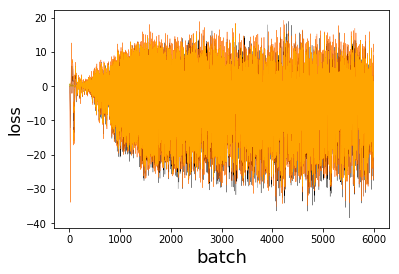

In [13]:
fig = plt.figure()
plt.plot([x[0] for x in gan.critic_valid_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.critic_valid_losses], color='green', linewidth=0.25)
plt.plot([x[0] for x in gan.critic_generated_losses], color='red', linewidth=0.25)
plt.plot(gan.generator_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [14]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [15]:

r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator_model.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()